In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 12%|███████▋                                                      | 7480/60000 [00:00<00:00, 74796.68it/s]

 25%|███████████████▏                                             | 14960/60000 [00:00<00:00, 74737.57it/s]

 37%|██████████████████████▊                                      | 22434/60000 [00:00<00:00, 72971.46it/s]

 50%|██████████████████████████████▏                              | 29736/60000 [00:00<00:00, 72467.97it/s]

 62%|█████████████████████████████████████▋                       | 37102/60000 [00:00<00:00, 72891.02it/s]

 74%|█████████████████████████████████████████████▎               | 44587/60000 [00:00<00:00, 73550.13it/s]

 87%|████████████████████████████████████████████████████▊        | 51945/60000 [00:00<00:00, 73024.73it/s]

 99%|████████████████████████████████████████████████████████████▍| 59431/60000 [00:00<00:00, 73601.95it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 73290.97it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████                | 7436/10000 [00:00<00:00, 74352.63it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 74014.47it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 mf83m6il


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/368 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/368 [00:01<07:02,  1.15s/it]

  1%|▍                                                                     | 2/368 [00:01<03:53,  1.57it/s]

  1%|▌                                                                     | 3/368 [00:01<02:51,  2.13it/s]

  1%|▊                                                                     | 4/368 [00:01<02:21,  2.57it/s]

  1%|▉                                                                     | 5/368 [00:02<02:05,  2.89it/s]

  2%|█▏                                                                    | 6/368 [00:02<01:55,  3.13it/s]

  2%|█▎                                                                    | 7/368 [00:02<01:49,  3.31it/s]

  2%|█▌                                                                    | 8/368 [00:03<01:44,  3.43it/s]

  2%|█▋                                                                    | 9/368 [00:03<01:37,  3.67it/s]

  3%|█▉                                                                   | 10/368 [00:03<01:38,  3.63it/s]

  3%|██                                                                   | 11/368 [00:03<01:37,  3.66it/s]

  3%|██▎                                                                  | 12/368 [00:04<01:36,  3.68it/s]

  4%|██▍                                                                  | 13/368 [00:04<01:36,  3.70it/s]

  4%|██▋                                                                  | 14/368 [00:04<01:35,  3.71it/s]

  4%|██▊                                                                  | 15/368 [00:04<01:35,  3.71it/s]

  4%|███                                                                  | 16/368 [00:05<01:34,  3.72it/s]

  5%|███▏                                                                 | 17/368 [00:05<01:34,  3.72it/s]

  5%|███▍                                                                 | 18/368 [00:05<01:33,  3.73it/s]

  5%|███▌                                                                 | 19/368 [00:05<01:33,  3.73it/s]

  5%|███▊                                                                 | 20/368 [00:06<01:33,  3.73it/s]

  6%|███▉                                                                 | 21/368 [00:06<01:33,  3.73it/s]

  6%|████▏                                                                | 22/368 [00:06<01:32,  3.73it/s]

  6%|████▎                                                                | 23/368 [00:07<01:32,  3.73it/s]

  7%|████▌                                                                | 24/368 [00:07<01:32,  3.73it/s]

  7%|████▋                                                                | 25/368 [00:07<01:31,  3.73it/s]

  7%|████▉                                                                | 26/368 [00:07<01:31,  3.73it/s]

  7%|█████                                                                | 27/368 [00:08<01:31,  3.73it/s]

  8%|█████▎                                                               | 28/368 [00:08<01:31,  3.73it/s]

  8%|█████▍                                                               | 29/368 [00:08<01:30,  3.73it/s]

  8%|█████▋                                                               | 30/368 [00:08<01:30,  3.73it/s]

  8%|█████▊                                                               | 31/368 [00:09<01:30,  3.73it/s]

  9%|██████                                                               | 32/368 [00:09<01:30,  3.73it/s]

  9%|██████▏                                                              | 33/368 [00:09<01:29,  3.73it/s]

  9%|██████▍                                                              | 34/368 [00:09<01:29,  3.73it/s]

 10%|██████▌                                                              | 35/368 [00:10<01:29,  3.73it/s]

 10%|██████▊                                                              | 36/368 [00:10<01:29,  3.73it/s]

 10%|██████▉                                                              | 37/368 [00:10<01:28,  3.73it/s]

 10%|███████▏                                                             | 38/368 [00:11<01:28,  3.73it/s]

 11%|███████▎                                                             | 39/368 [00:11<01:28,  3.73it/s]

 11%|███████▌                                                             | 40/368 [00:11<01:27,  3.73it/s]

 11%|███████▋                                                             | 41/368 [00:11<01:27,  3.73it/s]

 11%|███████▊                                                             | 42/368 [00:12<01:27,  3.73it/s]

 12%|████████                                                             | 43/368 [00:12<01:27,  3.73it/s]

 12%|████████▎                                                            | 44/368 [00:12<01:26,  3.73it/s]

 12%|████████▍                                                            | 45/368 [00:12<01:26,  3.73it/s]

 12%|████████▋                                                            | 46/368 [00:13<01:26,  3.73it/s]

 13%|████████▊                                                            | 47/368 [00:13<01:26,  3.73it/s]

 13%|█████████                                                            | 48/368 [00:13<01:25,  3.73it/s]

 13%|█████████▏                                                           | 49/368 [00:14<01:25,  3.73it/s]

 14%|█████████▍                                                           | 50/368 [00:14<01:25,  3.73it/s]

 14%|█████████▌                                                           | 51/368 [00:14<01:24,  3.73it/s]

 14%|█████████▊                                                           | 52/368 [00:14<01:24,  3.73it/s]

 14%|█████████▉                                                           | 53/368 [00:15<01:24,  3.73it/s]

 15%|██████████▏                                                          | 54/368 [00:15<01:24,  3.73it/s]

 15%|██████████▎                                                          | 55/368 [00:15<01:23,  3.73it/s]

 15%|██████████▌                                                          | 56/368 [00:15<01:23,  3.73it/s]

 15%|██████████▋                                                          | 57/368 [00:16<01:23,  3.73it/s]

 16%|██████████▉                                                          | 58/368 [00:16<01:23,  3.73it/s]

 16%|███████████                                                          | 59/368 [00:16<01:22,  3.73it/s]

 16%|███████████▎                                                         | 60/368 [00:16<01:22,  3.73it/s]

 17%|███████████▍                                                         | 61/368 [00:17<01:22,  3.73it/s]

 17%|███████████▋                                                         | 62/368 [00:17<01:22,  3.73it/s]

 17%|███████████▊                                                         | 63/368 [00:17<01:21,  3.73it/s]

 17%|████████████                                                         | 64/368 [00:18<01:21,  3.73it/s]

 18%|████████████▏                                                        | 65/368 [00:18<01:21,  3.73it/s]

 18%|████████████▍                                                        | 66/368 [00:18<01:20,  3.73it/s]

 18%|████████████▌                                                        | 67/368 [00:18<01:20,  3.73it/s]

 18%|████████████▊                                                        | 68/368 [00:19<01:20,  3.73it/s]

 19%|████████████▉                                                        | 69/368 [00:19<01:20,  3.73it/s]

 19%|█████████████▏                                                       | 70/368 [00:19<01:19,  3.73it/s]

 19%|█████████████▎                                                       | 71/368 [00:19<01:19,  3.73it/s]

 20%|█████████████▌                                                       | 72/368 [00:20<01:19,  3.73it/s]

 20%|█████████████▋                                                       | 73/368 [00:20<01:19,  3.73it/s]

 20%|█████████████▉                                                       | 74/368 [00:20<01:18,  3.73it/s]

 20%|██████████████                                                       | 75/368 [00:20<01:18,  3.73it/s]

 21%|██████████████▎                                                      | 76/368 [00:21<01:18,  3.73it/s]

 21%|██████████████▍                                                      | 77/368 [00:21<01:17,  3.73it/s]

 21%|██████████████▋                                                      | 78/368 [00:21<01:17,  3.73it/s]

 21%|██████████████▊                                                      | 79/368 [00:22<01:17,  3.73it/s]

 22%|███████████████                                                      | 80/368 [00:22<01:17,  3.73it/s]

 22%|███████████████▏                                                     | 81/368 [00:22<01:16,  3.73it/s]

 22%|███████████████▍                                                     | 82/368 [00:22<01:16,  3.73it/s]

 23%|███████████████▌                                                     | 83/368 [00:23<01:16,  3.73it/s]

 23%|███████████████▋                                                     | 84/368 [00:23<01:16,  3.73it/s]

 23%|███████████████▉                                                     | 85/368 [00:23<01:15,  3.73it/s]

 23%|████████████████▏                                                    | 86/368 [00:23<01:15,  3.73it/s]

 24%|████████████████▎                                                    | 87/368 [00:24<01:15,  3.73it/s]

 24%|████████████████▌                                                    | 88/368 [00:24<01:15,  3.73it/s]

 24%|████████████████▋                                                    | 89/368 [00:24<01:14,  3.73it/s]

 24%|████████████████▉                                                    | 90/368 [00:24<01:14,  3.73it/s]

 25%|█████████████████                                                    | 91/368 [00:25<01:14,  3.73it/s]

 25%|█████████████████▎                                                   | 92/368 [00:25<01:13,  3.73it/s]

 25%|█████████████████▍                                                   | 93/368 [00:25<01:13,  3.73it/s]

 26%|█████████████████▋                                                   | 94/368 [00:26<01:13,  3.73it/s]

 26%|█████████████████▊                                                   | 95/368 [00:26<01:13,  3.73it/s]

 26%|██████████████████                                                   | 96/368 [00:26<01:12,  3.73it/s]

 26%|██████████████████▏                                                  | 97/368 [00:26<01:12,  3.73it/s]

 27%|██████████████████▍                                                  | 98/368 [00:27<01:12,  3.73it/s]

 27%|██████████████████▌                                                  | 99/368 [00:27<01:12,  3.73it/s]

 27%|██████████████████▍                                                 | 100/368 [00:27<01:11,  3.73it/s]

 27%|██████████████████▋                                                 | 101/368 [00:27<01:11,  3.73it/s]

 28%|██████████████████▊                                                 | 102/368 [00:28<01:11,  3.73it/s]

 28%|███████████████████                                                 | 103/368 [00:28<01:11,  3.73it/s]

 28%|███████████████████▏                                                | 104/368 [00:28<01:10,  3.73it/s]

 29%|███████████████████▍                                                | 105/368 [00:29<01:10,  3.73it/s]

 29%|███████████████████▌                                                | 106/368 [00:29<01:10,  3.73it/s]

 29%|███████████████████▊                                                | 107/368 [00:29<01:09,  3.73it/s]

 29%|███████████████████▉                                                | 108/368 [00:29<01:09,  3.73it/s]

 30%|████████████████████▏                                               | 109/368 [00:30<01:09,  3.73it/s]

 30%|████████████████████▎                                               | 110/368 [00:30<01:09,  3.73it/s]

 30%|████████████████████▌                                               | 111/368 [00:30<01:08,  3.73it/s]

 30%|████████████████████▋                                               | 112/368 [00:30<01:08,  3.73it/s]

 31%|████████████████████▉                                               | 113/368 [00:31<01:08,  3.73it/s]

 31%|█████████████████████                                               | 114/368 [00:31<01:08,  3.73it/s]

 31%|█████████████████████▎                                              | 115/368 [00:31<01:07,  3.73it/s]

 32%|█████████████████████▍                                              | 116/368 [00:31<01:07,  3.73it/s]

 32%|█████████████████████▌                                              | 117/368 [00:32<01:07,  3.73it/s]

 32%|█████████████████████▊                                              | 118/368 [00:32<01:06,  3.73it/s]

 32%|█████████████████████▉                                              | 119/368 [00:32<01:06,  3.73it/s]

 33%|██████████████████████▏                                             | 120/368 [00:33<01:06,  3.73it/s]

 33%|██████████████████████▎                                             | 121/368 [00:33<01:06,  3.73it/s]

 33%|██████████████████████▌                                             | 122/368 [00:33<01:05,  3.73it/s]

 33%|██████████████████████▋                                             | 123/368 [00:33<01:05,  3.73it/s]

 34%|██████████████████████▉                                             | 124/368 [00:34<01:05,  3.73it/s]

 34%|███████████████████████                                             | 125/368 [00:34<01:05,  3.73it/s]

 34%|███████████████████████▎                                            | 126/368 [00:34<01:04,  3.73it/s]

 35%|███████████████████████▍                                            | 127/368 [00:34<01:04,  3.73it/s]

 35%|███████████████████████▋                                            | 128/368 [00:35<01:04,  3.73it/s]

 35%|███████████████████████▊                                            | 129/368 [00:35<01:04,  3.73it/s]

 35%|████████████████████████                                            | 130/368 [00:35<01:03,  3.73it/s]

 36%|████████████████████████▏                                           | 131/368 [00:35<01:03,  3.73it/s]

 36%|████████████████████████▍                                           | 132/368 [00:36<01:03,  3.73it/s]

 36%|████████████████████████▌                                           | 133/368 [00:36<01:02,  3.73it/s]

 36%|████████████████████████▊                                           | 134/368 [00:36<01:02,  3.73it/s]

 37%|████████████████████████▉                                           | 135/368 [00:37<01:02,  3.73it/s]

 37%|█████████████████████████▏                                          | 136/368 [00:37<01:02,  3.73it/s]

 37%|█████████████████████████▎                                          | 137/368 [00:37<01:01,  3.73it/s]

 38%|█████████████████████████▌                                          | 138/368 [00:37<01:01,  3.73it/s]

 38%|█████████████████████████▋                                          | 139/368 [00:38<01:01,  3.73it/s]

 38%|█████████████████████████▊                                          | 140/368 [00:38<01:01,  3.73it/s]

 38%|██████████████████████████                                          | 141/368 [00:38<01:00,  3.73it/s]

 39%|██████████████████████████▏                                         | 142/368 [00:38<01:00,  3.73it/s]

 39%|██████████████████████████▍                                         | 143/368 [00:39<01:00,  3.73it/s]

 39%|██████████████████████████▌                                         | 144/368 [00:39<01:00,  3.73it/s]

 39%|██████████████████████████▊                                         | 145/368 [00:39<00:59,  3.73it/s]

 40%|██████████████████████████▉                                         | 146/368 [00:39<00:59,  3.73it/s]

 40%|███████████████████████████▏                                        | 147/368 [00:40<00:59,  3.73it/s]

 40%|███████████████████████████▎                                        | 148/368 [00:40<00:58,  3.73it/s]

 40%|███████████████████████████▌                                        | 149/368 [00:40<00:58,  3.73it/s]

 41%|███████████████████████████▋                                        | 150/368 [00:41<00:58,  3.73it/s]

 41%|███████████████████████████▉                                        | 151/368 [00:41<00:58,  3.73it/s]

 41%|████████████████████████████                                        | 152/368 [00:41<00:57,  3.73it/s]

 42%|████████████████████████████▎                                       | 153/368 [00:41<00:57,  3.73it/s]

 42%|████████████████████████████▍                                       | 154/368 [00:42<00:57,  3.73it/s]

 42%|████████████████████████████▋                                       | 155/368 [00:42<00:57,  3.73it/s]

 42%|████████████████████████████▊                                       | 156/368 [00:42<00:56,  3.73it/s]

 43%|█████████████████████████████                                       | 157/368 [00:42<00:56,  3.73it/s]

 43%|█████████████████████████████▏                                      | 158/368 [00:43<00:56,  3.73it/s]

 43%|█████████████████████████████▍                                      | 159/368 [00:43<00:56,  3.73it/s]

 43%|█████████████████████████████▌                                      | 160/368 [00:43<00:55,  3.73it/s]

 44%|█████████████████████████████▊                                      | 161/368 [00:44<00:55,  3.73it/s]

 44%|█████████████████████████████▉                                      | 162/368 [00:44<00:55,  3.73it/s]

 44%|██████████████████████████████                                      | 163/368 [00:44<00:54,  3.73it/s]

 45%|██████████████████████████████▎                                     | 164/368 [00:44<00:54,  3.73it/s]

 45%|██████████████████████████████▍                                     | 165/368 [00:45<00:54,  3.73it/s]

 45%|██████████████████████████████▋                                     | 166/368 [00:45<00:54,  3.73it/s]

 45%|██████████████████████████████▊                                     | 167/368 [00:45<00:53,  3.73it/s]

 46%|███████████████████████████████                                     | 168/368 [00:45<00:53,  3.73it/s]

 46%|███████████████████████████████▏                                    | 169/368 [00:46<00:53,  3.73it/s]

 46%|███████████████████████████████▍                                    | 170/368 [00:46<00:53,  3.73it/s]

 46%|███████████████████████████████▌                                    | 171/368 [00:46<00:52,  3.73it/s]

 47%|███████████████████████████████▊                                    | 172/368 [00:46<00:52,  3.73it/s]

 47%|███████████████████████████████▉                                    | 173/368 [00:47<00:52,  3.73it/s]

 47%|████████████████████████████████▏                                   | 174/368 [00:47<00:52,  3.73it/s]

 48%|████████████████████████████████▎                                   | 175/368 [00:47<00:51,  3.73it/s]

 48%|████████████████████████████████▌                                   | 176/368 [00:48<00:51,  3.73it/s]

 48%|████████████████████████████████▋                                   | 177/368 [00:48<00:51,  3.73it/s]

 48%|████████████████████████████████▉                                   | 178/368 [00:48<00:50,  3.73it/s]

 49%|█████████████████████████████████                                   | 179/368 [00:48<00:50,  3.73it/s]

 49%|█████████████████████████████████▎                                  | 180/368 [00:49<00:50,  3.73it/s]

 49%|█████████████████████████████████▍                                  | 181/368 [00:49<00:50,  3.73it/s]

 49%|█████████████████████████████████▋                                  | 182/368 [00:49<00:49,  3.73it/s]

 50%|█████████████████████████████████▊                                  | 183/368 [00:49<00:49,  3.73it/s]

 50%|██████████████████████████████████                                  | 184/368 [00:50<00:49,  3.73it/s]

 50%|██████████████████████████████████▏                                 | 185/368 [00:50<00:49,  3.73it/s]

 51%|██████████████████████████████████▎                                 | 186/368 [00:50<00:48,  3.73it/s]

 51%|██████████████████████████████████▌                                 | 187/368 [00:50<00:48,  3.73it/s]

 51%|██████████████████████████████████▋                                 | 188/368 [00:51<00:48,  3.73it/s]

 51%|██████████████████████████████████▉                                 | 189/368 [00:51<00:48,  3.73it/s]

 52%|███████████████████████████████████                                 | 190/368 [00:51<00:47,  3.73it/s]

 52%|███████████████████████████████████▎                                | 191/368 [00:52<00:47,  3.73it/s]

 52%|███████████████████████████████████▍                                | 192/368 [00:52<00:47,  3.73it/s]

 52%|███████████████████████████████████▋                                | 193/368 [00:52<00:46,  3.73it/s]

 53%|███████████████████████████████████▊                                | 194/368 [00:52<00:46,  3.73it/s]

 53%|████████████████████████████████████                                | 195/368 [00:53<00:46,  3.73it/s]

 53%|████████████████████████████████████▏                               | 196/368 [00:53<00:46,  3.73it/s]

 54%|████████████████████████████████████▍                               | 197/368 [00:53<00:45,  3.73it/s]

 54%|████████████████████████████████████▌                               | 198/368 [00:53<00:45,  3.73it/s]

 54%|████████████████████████████████████▊                               | 199/368 [00:54<00:45,  3.73it/s]

 54%|████████████████████████████████████▉                               | 200/368 [00:54<00:45,  3.73it/s]

 55%|█████████████████████████████████████▏                              | 201/368 [00:54<00:44,  3.73it/s]

 55%|█████████████████████████████████████▎                              | 202/368 [00:55<00:44,  3.73it/s]

 55%|█████████████████████████████████████▌                              | 203/368 [00:55<00:44,  3.73it/s]

 55%|█████████████████████████████████████▋                              | 204/368 [00:55<00:43,  3.73it/s]

 56%|█████████████████████████████████████▉                              | 205/368 [00:55<00:43,  3.73it/s]

 56%|██████████████████████████████████████                              | 206/368 [00:56<00:43,  3.73it/s]

 56%|██████████████████████████████████████▎                             | 207/368 [00:56<00:43,  3.73it/s]

 57%|██████████████████████████████████████▍                             | 208/368 [00:56<00:42,  3.73it/s]

 57%|██████████████████████████████████████▌                             | 209/368 [00:56<00:42,  3.73it/s]

 57%|██████████████████████████████████████▊                             | 210/368 [00:57<00:42,  3.73it/s]

 57%|██████████████████████████████████████▉                             | 211/368 [00:57<00:42,  3.73it/s]

 58%|███████████████████████████████████████▏                            | 212/368 [00:57<00:41,  3.73it/s]

 58%|███████████████████████████████████████▎                            | 213/368 [00:57<00:41,  3.73it/s]

 58%|███████████████████████████████████████▌                            | 214/368 [00:58<00:41,  3.73it/s]

 58%|███████████████████████████████████████▋                            | 215/368 [00:58<00:41,  3.73it/s]

 59%|███████████████████████████████████████▉                            | 216/368 [00:58<00:40,  3.73it/s]

 59%|████████████████████████████████████████                            | 217/368 [00:59<00:40,  3.73it/s]

 59%|████████████████████████████████████████▎                           | 218/368 [00:59<00:40,  3.73it/s]

 60%|████████████████████████████████████████▍                           | 219/368 [00:59<00:39,  3.73it/s]

 60%|████████████████████████████████████████▋                           | 220/368 [00:59<00:39,  3.73it/s]

 60%|████████████████████████████████████████▊                           | 221/368 [01:00<00:39,  3.73it/s]

 60%|█████████████████████████████████████████                           | 222/368 [01:00<00:39,  3.73it/s]

 61%|█████████████████████████████████████████▏                          | 223/368 [01:00<00:38,  3.73it/s]

 61%|█████████████████████████████████████████▍                          | 224/368 [01:00<00:38,  3.73it/s]

 61%|█████████████████████████████████████████▌                          | 225/368 [01:01<00:38,  3.73it/s]

 61%|█████████████████████████████████████████▊                          | 226/368 [01:01<00:38,  3.73it/s]

 62%|█████████████████████████████████████████▉                          | 227/368 [01:01<00:37,  3.73it/s]

 62%|██████████████████████████████████████████▏                         | 228/368 [01:01<00:37,  3.73it/s]

 62%|██████████████████████████████████████████▎                         | 229/368 [01:02<00:37,  3.73it/s]

 62%|██████████████████████████████████████████▌                         | 230/368 [01:02<00:36,  3.73it/s]

 63%|██████████████████████████████████████████▋                         | 231/368 [01:02<00:36,  3.73it/s]

 63%|██████████████████████████████████████████▊                         | 232/368 [01:03<00:36,  3.73it/s]

 63%|███████████████████████████████████████████                         | 233/368 [01:03<00:36,  3.73it/s]

 64%|███████████████████████████████████████████▏                        | 234/368 [01:03<00:35,  3.73it/s]

 64%|███████████████████████████████████████████▍                        | 235/368 [01:03<00:35,  3.73it/s]

 64%|███████████████████████████████████████████▌                        | 236/368 [01:04<00:34,  3.79it/s]

 64%|███████████████████████████████████████████▊                        | 237/368 [01:04<00:35,  3.71it/s]

 65%|███████████████████████████████████████████▉                        | 238/368 [01:04<00:34,  3.71it/s]

 65%|████████████████████████████████████████████▏                       | 239/368 [01:04<00:34,  3.72it/s]

 65%|████████████████████████████████████████████▎                       | 240/368 [01:05<00:34,  3.72it/s]

 65%|████████████████████████████████████████████▌                       | 241/368 [01:05<00:34,  3.72it/s]

 66%|████████████████████████████████████████████▋                       | 242/368 [01:05<00:33,  3.73it/s]

 66%|████████████████████████████████████████████▉                       | 243/368 [01:06<00:33,  3.73it/s]

 66%|█████████████████████████████████████████████                       | 244/368 [01:06<00:33,  3.73it/s]

 67%|█████████████████████████████████████████████▎                      | 245/368 [01:06<00:32,  3.73it/s]

 67%|█████████████████████████████████████████████▍                      | 246/368 [01:06<00:32,  3.79it/s]

 67%|█████████████████████████████████████████████▋                      | 247/368 [01:07<00:32,  3.71it/s]

 67%|█████████████████████████████████████████████▊                      | 248/368 [01:07<00:32,  3.71it/s]

 68%|██████████████████████████████████████████████                      | 249/368 [01:07<00:32,  3.72it/s]

 68%|██████████████████████████████████████████████▏                     | 250/368 [01:07<00:31,  3.72it/s]

 68%|██████████████████████████████████████████████▍                     | 251/368 [01:08<00:31,  3.73it/s]

 68%|██████████████████████████████████████████████▌                     | 252/368 [01:08<00:31,  3.73it/s]

 69%|██████████████████████████████████████████████▊                     | 253/368 [01:08<00:30,  3.73it/s]

 69%|██████████████████████████████████████████████▉                     | 254/368 [01:08<00:30,  3.73it/s]

 69%|███████████████████████████████████████████████                     | 255/368 [01:09<00:30,  3.73it/s]

 70%|███████████████████████████████████████████████▎                    | 256/368 [01:09<00:30,  3.73it/s]

 70%|███████████████████████████████████████████████▍                    | 257/368 [01:09<00:29,  3.73it/s]

 70%|███████████████████████████████████████████████▋                    | 258/368 [01:10<00:29,  3.73it/s]

 70%|███████████████████████████████████████████████▊                    | 259/368 [01:10<00:29,  3.73it/s]

 71%|████████████████████████████████████████████████                    | 260/368 [01:10<00:28,  3.73it/s]

 71%|████████████████████████████████████████████████▏                   | 261/368 [01:10<00:28,  3.73it/s]

 71%|████████████████████████████████████████████████▍                   | 262/368 [01:11<00:28,  3.73it/s]

 71%|████████████████████████████████████████████████▌                   | 263/368 [01:11<00:28,  3.73it/s]

 72%|████████████████████████████████████████████████▊                   | 264/368 [01:11<00:27,  3.73it/s]

 72%|████████████████████████████████████████████████▉                   | 265/368 [01:11<00:27,  3.73it/s]

 72%|█████████████████████████████████████████████████▏                  | 266/368 [01:12<00:27,  3.73it/s]

 73%|█████████████████████████████████████████████████▎                  | 267/368 [01:12<00:27,  3.73it/s]

 73%|█████████████████████████████████████████████████▌                  | 268/368 [01:12<00:26,  3.73it/s]

 73%|█████████████████████████████████████████████████▋                  | 269/368 [01:12<00:26,  3.73it/s]

 73%|█████████████████████████████████████████████████▉                  | 270/368 [01:13<00:26,  3.73it/s]

 74%|██████████████████████████████████████████████████                  | 271/368 [01:13<00:26,  3.73it/s]

 74%|██████████████████████████████████████████████████▎                 | 272/368 [01:13<00:25,  3.73it/s]

 74%|██████████████████████████████████████████████████▍                 | 273/368 [01:14<00:25,  3.73it/s]

 74%|██████████████████████████████████████████████████▋                 | 274/368 [01:14<00:25,  3.73it/s]

 75%|██████████████████████████████████████████████████▊                 | 275/368 [01:14<00:24,  3.73it/s]

 75%|███████████████████████████████████████████████████                 | 276/368 [01:14<00:24,  3.73it/s]

 75%|███████████████████████████████████████████████████▏                | 277/368 [01:15<00:24,  3.73it/s]

 76%|███████████████████████████████████████████████████▎                | 278/368 [01:15<00:24,  3.73it/s]

 76%|███████████████████████████████████████████████████▌                | 279/368 [01:15<00:23,  3.73it/s]

 76%|███████████████████████████████████████████████████▋                | 280/368 [01:15<00:23,  3.73it/s]

 76%|███████████████████████████████████████████████████▉                | 281/368 [01:16<00:23,  3.73it/s]

 77%|████████████████████████████████████████████████████                | 282/368 [01:16<00:23,  3.73it/s]

 77%|████████████████████████████████████████████████████▎               | 283/368 [01:16<00:22,  3.73it/s]

 77%|████████████████████████████████████████████████████▍               | 284/368 [01:16<00:22,  3.73it/s]

 77%|████████████████████████████████████████████████████▋               | 285/368 [01:17<00:22,  3.73it/s]

 78%|████████████████████████████████████████████████████▊               | 286/368 [01:17<00:21,  3.73it/s]

 78%|█████████████████████████████████████████████████████               | 287/368 [01:17<00:21,  3.73it/s]

 78%|█████████████████████████████████████████████████████▏              | 288/368 [01:18<00:21,  3.73it/s]

 79%|█████████████████████████████████████████████████████▍              | 289/368 [01:18<00:21,  3.73it/s]

 79%|█████████████████████████████████████████████████████▌              | 290/368 [01:18<00:20,  3.73it/s]

 79%|█████████████████████████████████████████████████████▊              | 291/368 [01:18<00:20,  3.73it/s]

 79%|█████████████████████████████████████████████████████▉              | 292/368 [01:19<00:20,  3.73it/s]

 80%|██████████████████████████████████████████████████████▏             | 293/368 [01:19<00:20,  3.73it/s]

 80%|██████████████████████████████████████████████████████▎             | 294/368 [01:19<00:19,  3.73it/s]

 80%|██████████████████████████████████████████████████████▌             | 295/368 [01:19<00:19,  3.73it/s]

 80%|██████████████████████████████████████████████████████▋             | 296/368 [01:20<00:19,  3.73it/s]

 81%|██████████████████████████████████████████████████████▉             | 297/368 [01:20<00:19,  3.73it/s]

 81%|███████████████████████████████████████████████████████             | 298/368 [01:20<00:18,  3.73it/s]

 81%|███████████████████████████████████████████████████████▎            | 299/368 [01:21<00:18,  3.73it/s]

 82%|███████████████████████████████████████████████████████▍            | 300/368 [01:21<00:18,  3.73it/s]

 82%|███████████████████████████████████████████████████████▌            | 301/368 [01:21<00:17,  3.73it/s]

 82%|███████████████████████████████████████████████████████▊            | 302/368 [01:21<00:17,  3.73it/s]

 82%|███████████████████████████████████████████████████████▉            | 303/368 [01:22<00:17,  3.73it/s]

 83%|████████████████████████████████████████████████████████▏           | 304/368 [01:22<00:17,  3.73it/s]

 83%|████████████████████████████████████████████████████████▎           | 305/368 [01:22<00:16,  3.73it/s]

 83%|████████████████████████████████████████████████████████▌           | 306/368 [01:22<00:16,  3.73it/s]

 83%|████████████████████████████████████████████████████████▋           | 307/368 [01:23<00:16,  3.73it/s]

 84%|████████████████████████████████████████████████████████▉           | 308/368 [01:23<00:16,  3.73it/s]

 84%|█████████████████████████████████████████████████████████           | 309/368 [01:23<00:15,  3.73it/s]

 84%|█████████████████████████████████████████████████████████▎          | 310/368 [01:23<00:15,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▍          | 311/368 [01:24<00:15,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▋          | 312/368 [01:24<00:15,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▊          | 313/368 [01:24<00:14,  3.73it/s]

 85%|██████████████████████████████████████████████████████████          | 314/368 [01:25<00:14,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▏         | 315/368 [01:25<00:14,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▍         | 316/368 [01:25<00:13,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▌         | 317/368 [01:25<00:13,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▊         | 318/368 [01:26<00:13,  3.73it/s]

 87%|██████████████████████████████████████████████████████████▉         | 319/368 [01:26<00:13,  3.73it/s]

 87%|███████████████████████████████████████████████████████████▏        | 320/368 [01:26<00:12,  3.73it/s]

 87%|███████████████████████████████████████████████████████████▎        | 321/368 [01:26<00:12,  3.73it/s]

 88%|███████████████████████████████████████████████████████████▌        | 322/368 [01:27<00:12,  3.73it/s]

 88%|███████████████████████████████████████████████████████████▋        | 323/368 [01:27<00:11,  3.79it/s]

 88%|███████████████████████████████████████████████████████████▊        | 324/368 [01:27<00:11,  3.71it/s]

 88%|████████████████████████████████████████████████████████████        | 325/368 [01:27<00:11,  3.72it/s]

 89%|████████████████████████████████████████████████████████████▏       | 326/368 [01:28<00:11,  3.72it/s]

 89%|████████████████████████████████████████████████████████████▍       | 327/368 [01:28<00:11,  3.72it/s]

 89%|████████████████████████████████████████████████████████████▌       | 328/368 [01:28<00:10,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▊       | 329/368 [01:29<00:10,  3.73it/s]

 90%|████████████████████████████████████████████████████████████▉       | 330/368 [01:29<00:10,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 331/368 [01:29<00:09,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 332/368 [01:29<00:09,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████▌      | 333/368 [01:30<00:09,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 334/368 [01:30<00:09,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 335/368 [01:30<00:08,  3.73it/s]

 91%|██████████████████████████████████████████████████████████████      | 336/368 [01:30<00:08,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 337/368 [01:31<00:08,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 338/368 [01:31<00:08,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 339/368 [01:31<00:07,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 340/368 [01:31<00:07,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████     | 341/368 [01:32<00:07,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 342/368 [01:32<00:06,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 343/368 [01:32<00:06,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 344/368 [01:33<00:06,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 345/368 [01:33<00:06,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 346/368 [01:33<00:05,  3.73it/s]

 94%|████████████████████████████████████████████████████████████████    | 347/368 [01:33<00:05,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 348/368 [01:34<00:05,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 349/368 [01:34<00:05,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 350/368 [01:34<00:04,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 351/368 [01:34<00:04,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████   | 352/368 [01:35<00:04,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 353/368 [01:35<00:04,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 354/368 [01:35<00:03,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 355/368 [01:36<00:03,  3.73it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 356/368 [01:36<00:03,  3.73it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 357/368 [01:36<00:02,  3.73it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 358/368 [01:36<00:02,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 359/368 [01:37<00:02,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 360/368 [01:37<00:02,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 361/368 [01:37<00:01,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 362/368 [01:37<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████ | 363/368 [01:38<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 364/368 [01:38<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 365/368 [01:38<00:00,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▋| 366/368 [01:38<00:00,  3.73it/s]

100%|███████████████████████████████████████████████████████████████████▊| 367/368 [01:39<00:00,  3.73it/s]

100%|████████████████████████████████████████████████████████████████████| 368/368 [01:39<00:00,  3.80it/s]

100%|████████████████████████████████████████████████████████████████████| 368/368 [01:39<00:00,  3.70it/s]

train - OK


  0%|                                                                               | 0/92 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/92 [00:00<00:30,  2.99it/s]

  2%|█▌                                                                     | 2/92 [00:00<00:26,  3.39it/s]

  3%|██▎                                                                    | 3/92 [00:00<00:25,  3.54it/s]

  4%|███                                                                    | 4/92 [00:01<00:24,  3.61it/s]

  5%|███▊                                                                   | 5/92 [00:01<00:23,  3.65it/s]

  7%|████▋                                                                  | 6/92 [00:01<00:23,  3.68it/s]

  8%|█████▍                                                                 | 7/92 [00:01<00:22,  3.81it/s]

  9%|██████▏                                                                | 8/92 [00:02<00:22,  3.78it/s]

 10%|██████▉                                                                | 9/92 [00:02<00:22,  3.77it/s]

 11%|███████▌                                                              | 10/92 [00:02<00:21,  3.76it/s]

 12%|████████▎                                                             | 11/92 [00:02<00:21,  3.75it/s]

 13%|█████████▏                                                            | 12/92 [00:03<00:21,  3.74it/s]

 14%|█████████▉                                                            | 13/92 [00:03<00:21,  3.74it/s]

 15%|██████████▋                                                           | 14/92 [00:03<00:20,  3.74it/s]

 16%|███████████▍                                                          | 15/92 [00:04<00:20,  3.74it/s]

 17%|████████████▏                                                         | 16/92 [00:04<00:20,  3.74it/s]

 18%|████████████▉                                                         | 17/92 [00:04<00:20,  3.73it/s]

 20%|█████████████▋                                                        | 18/92 [00:04<00:19,  3.73it/s]

 21%|██████████████▍                                                       | 19/92 [00:05<00:19,  3.73it/s]

 22%|███████████████▏                                                      | 20/92 [00:05<00:19,  3.73it/s]

 23%|███████████████▉                                                      | 21/92 [00:05<00:19,  3.73it/s]

 24%|████████████████▋                                                     | 22/92 [00:05<00:18,  3.73it/s]

 25%|█████████████████▌                                                    | 23/92 [00:06<00:18,  3.73it/s]

 26%|██████████████████▎                                                   | 24/92 [00:06<00:18,  3.73it/s]

 27%|███████████████████                                                   | 25/92 [00:06<00:17,  3.73it/s]

 28%|███████████████████▊                                                  | 26/92 [00:07<00:17,  3.73it/s]

 29%|████████████████████▌                                                 | 27/92 [00:07<00:17,  3.73it/s]

 30%|█████████████████████▎                                                | 28/92 [00:07<00:17,  3.73it/s]

 32%|██████████████████████                                                | 29/92 [00:07<00:16,  3.73it/s]

 33%|██████████████████████▊                                               | 30/92 [00:08<00:16,  3.73it/s]

 34%|███████████████████████▌                                              | 31/92 [00:08<00:16,  3.73it/s]

 35%|████████████████████████▎                                             | 32/92 [00:08<00:16,  3.73it/s]

 36%|█████████████████████████                                             | 33/92 [00:08<00:15,  3.73it/s]

 37%|█████████████████████████▊                                            | 34/92 [00:09<00:15,  3.73it/s]

 38%|██████████████████████████▋                                           | 35/92 [00:09<00:15,  3.73it/s]

 39%|███████████████████████████▍                                          | 36/92 [00:09<00:15,  3.73it/s]

 40%|████████████████████████████▏                                         | 37/92 [00:09<00:14,  3.73it/s]

 41%|████████████████████████████▉                                         | 38/92 [00:10<00:14,  3.73it/s]

 42%|█████████████████████████████▋                                        | 39/92 [00:10<00:14,  3.73it/s]

 43%|██████████████████████████████▍                                       | 40/92 [00:10<00:13,  3.73it/s]

 45%|███████████████████████████████▏                                      | 41/92 [00:11<00:13,  3.73it/s]

 46%|███████████████████████████████▉                                      | 42/92 [00:11<00:13,  3.73it/s]

 47%|████████████████████████████████▋                                     | 43/92 [00:11<00:13,  3.73it/s]

 48%|█████████████████████████████████▍                                    | 44/92 [00:11<00:12,  3.73it/s]

 49%|██████████████████████████████████▏                                   | 45/92 [00:12<00:12,  3.73it/s]

 50%|███████████████████████████████████                                   | 46/92 [00:12<00:12,  3.73it/s]

 51%|███████████████████████████████████▊                                  | 47/92 [00:12<00:12,  3.73it/s]

 52%|████████████████████████████████████▌                                 | 48/92 [00:12<00:11,  3.73it/s]

 53%|█████████████████████████████████████▎                                | 49/92 [00:13<00:11,  3.73it/s]

 54%|██████████████████████████████████████                                | 50/92 [00:13<00:11,  3.73it/s]

 55%|██████████████████████████████████████▊                               | 51/92 [00:13<00:10,  3.73it/s]

 57%|███████████████████████████████████████▌                              | 52/92 [00:13<00:10,  3.73it/s]

 58%|████████████████████████████████████████▎                             | 53/92 [00:14<00:10,  3.73it/s]

 59%|█████████████████████████████████████████                             | 54/92 [00:14<00:10,  3.73it/s]

 60%|█████████████████████████████████████████▊                            | 55/92 [00:14<00:09,  3.73it/s]

 61%|██████████████████████████████████████████▌                           | 56/92 [00:15<00:09,  3.73it/s]

 62%|███████████████████████████████████████████▎                          | 57/92 [00:15<00:09,  3.73it/s]

 63%|████████████████████████████████████████████▏                         | 58/92 [00:15<00:09,  3.73it/s]

 64%|████████████████████████████████████████████▉                         | 59/92 [00:15<00:08,  3.73it/s]

 65%|█████████████████████████████████████████████▋                        | 60/92 [00:16<00:08,  3.73it/s]

 66%|██████████████████████████████████████████████▍                       | 61/92 [00:16<00:08,  3.73it/s]

 67%|███████████████████████████████████████████████▏                      | 62/92 [00:16<00:08,  3.73it/s]

 68%|███████████████████████████████████████████████▉                      | 63/92 [00:16<00:07,  3.73it/s]

 70%|████████████████████████████████████████████████▋                     | 64/92 [00:17<00:07,  3.73it/s]

 71%|█████████████████████████████████████████████████▍                    | 65/92 [00:17<00:07,  3.79it/s]

 72%|██████████████████████████████████████████████████▏                   | 66/92 [00:17<00:07,  3.71it/s]

 73%|██████████████████████████████████████████████████▉                   | 67/92 [00:17<00:06,  3.72it/s]

 74%|███████████████████████████████████████████████████▋                  | 68/92 [00:18<00:06,  3.72it/s]

 75%|████████████████████████████████████████████████████▌                 | 69/92 [00:18<00:06,  3.72it/s]

 76%|█████████████████████████████████████████████████████▎                | 70/92 [00:18<00:05,  3.73it/s]

 77%|██████████████████████████████████████████████████████                | 71/92 [00:19<00:05,  3.73it/s]

 78%|██████████████████████████████████████████████████████▊               | 72/92 [00:19<00:05,  3.73it/s]

 79%|███████████████████████████████████████████████████████▌              | 73/92 [00:19<00:05,  3.73it/s]

 80%|████████████████████████████████████████████████████████▎             | 74/92 [00:19<00:04,  3.73it/s]

 82%|█████████████████████████████████████████████████████████             | 75/92 [00:20<00:04,  3.73it/s]

 83%|█████████████████████████████████████████████████████████▊            | 76/92 [00:20<00:04,  3.73it/s]

 84%|██████████████████████████████████████████████████████████▌           | 77/92 [00:20<00:04,  3.73it/s]

 85%|███████████████████████████████████████████████████████████▎          | 78/92 [00:20<00:03,  3.73it/s]

 86%|████████████████████████████████████████████████████████████          | 79/92 [00:21<00:03,  3.73it/s]

 87%|████████████████████████████████████████████████████████████▊         | 80/92 [00:21<00:03,  3.73it/s]

 88%|█████████████████████████████████████████████████████████████▋        | 81/92 [00:21<00:02,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████▍       | 82/92 [00:22<00:02,  3.73it/s]

 90%|███████████████████████████████████████████████████████████████▏      | 83/92 [00:22<00:02,  3.73it/s]

 91%|███████████████████████████████████████████████████████████████▉      | 84/92 [00:22<00:02,  3.73it/s]

 92%|████████████████████████████████████████████████████████████████▋     | 85/92 [00:22<00:01,  3.73it/s]

 93%|█████████████████████████████████████████████████████████████████▍    | 86/92 [00:23<00:01,  3.73it/s]

 95%|██████████████████████████████████████████████████████████████████▏   | 87/92 [00:23<00:01,  3.73it/s]

 96%|██████████████████████████████████████████████████████████████████▉   | 88/92 [00:23<00:01,  3.73it/s]

 97%|███████████████████████████████████████████████████████████████████▋  | 89/92 [00:23<00:00,  3.73it/s]

 98%|████████████████████████████████████████████████████████████████████▍ | 90/92 [00:24<00:00,  3.73it/s]

 99%|█████████████████████████████████████████████████████████████████████▏| 91/92 [00:24<00:00,  3.73it/s]

100%|██████████████████████████████████████████████████████████████████████| 92/92 [00:24<00:00,  3.64it/s]

100%|██████████████████████████████████████████████████████████████████████| 92/92 [00:24<00:00,  3.72it/s]

val - OK


  0%|                                                                               | 0/76 [00:00<?, ?it/s]

  1%|▉                                                                      | 1/76 [00:00<00:25,  2.99it/s]

  3%|█▊                                                                     | 2/76 [00:00<00:21,  3.38it/s]

  4%|██▊                                                                    | 3/76 [00:00<00:20,  3.53it/s]

  5%|███▋                                                                   | 4/76 [00:01<00:19,  3.61it/s]

  7%|████▋                                                                  | 5/76 [00:01<00:19,  3.65it/s]

  8%|█████▌                                                                 | 6/76 [00:01<00:19,  3.68it/s]

  9%|██████▌                                                                | 7/76 [00:01<00:18,  3.70it/s]

 11%|███████▍                                                               | 8/76 [00:02<00:18,  3.71it/s]

 12%|████████▍                                                              | 9/76 [00:02<00:18,  3.71it/s]

 13%|█████████▏                                                            | 10/76 [00:02<00:17,  3.72it/s]

 14%|██████████▏                                                           | 11/76 [00:03<00:17,  3.72it/s]

 16%|███████████                                                           | 12/76 [00:03<00:17,  3.72it/s]

 17%|███████████▉                                                          | 13/76 [00:03<00:16,  3.73it/s]

 18%|████████████▉                                                         | 14/76 [00:03<00:16,  3.73it/s]

 20%|█████████████▊                                                        | 15/76 [00:04<00:16,  3.73it/s]

 21%|██████████████▋                                                       | 16/76 [00:04<00:16,  3.73it/s]

 22%|███████████████▋                                                      | 17/76 [00:04<00:15,  3.73it/s]

 24%|████████████████▌                                                     | 18/76 [00:04<00:15,  3.73it/s]

 25%|█████████████████▌                                                    | 19/76 [00:05<00:15,  3.73it/s]

 26%|██████████████████▍                                                   | 20/76 [00:05<00:15,  3.73it/s]

 28%|███████████████████▎                                                  | 21/76 [00:05<00:14,  3.73it/s]

 29%|████████████████████▎                                                 | 22/76 [00:05<00:14,  3.73it/s]

 30%|█████████████████████▏                                                | 23/76 [00:06<00:14,  3.73it/s]

 32%|██████████████████████                                                | 24/76 [00:06<00:13,  3.73it/s]

 33%|███████████████████████                                               | 25/76 [00:06<00:13,  3.73it/s]

 34%|███████████████████████▉                                              | 26/76 [00:07<00:13,  3.73it/s]

 36%|████████████████████████▊                                             | 27/76 [00:07<00:13,  3.73it/s]

 37%|█████████████████████████▊                                            | 28/76 [00:07<00:12,  3.73it/s]

 38%|██████████████████████████▋                                           | 29/76 [00:07<00:12,  3.73it/s]

 39%|███████████████████████████▋                                          | 30/76 [00:08<00:12,  3.73it/s]

 41%|████████████████████████████▌                                         | 31/76 [00:08<00:12,  3.73it/s]

 42%|█████████████████████████████▍                                        | 32/76 [00:08<00:11,  3.73it/s]

 43%|██████████████████████████████▍                                       | 33/76 [00:08<00:11,  3.73it/s]

 45%|███████████████████████████████▎                                      | 34/76 [00:09<00:11,  3.73it/s]

 46%|████████████████████████████████▏                                     | 35/76 [00:09<00:10,  3.73it/s]

 47%|█████████████████████████████████▏                                    | 36/76 [00:09<00:10,  3.73it/s]

 49%|██████████████████████████████████                                    | 37/76 [00:09<00:10,  3.73it/s]

 50%|███████████████████████████████████                                   | 38/76 [00:10<00:10,  3.73it/s]

 51%|███████████████████████████████████▉                                  | 39/76 [00:10<00:09,  3.79it/s]

 53%|████████████████████████████████████▊                                 | 40/76 [00:10<00:09,  3.71it/s]

 54%|█████████████████████████████████████▊                                | 41/76 [00:11<00:09,  3.71it/s]

 55%|██████████████████████████████████████▋                               | 42/76 [00:11<00:09,  3.72it/s]

 57%|███████████████████████████████████████▌                              | 43/76 [00:11<00:08,  3.72it/s]

 58%|████████████████████████████████████████▌                             | 44/76 [00:11<00:08,  3.73it/s]

 59%|█████████████████████████████████████████▍                            | 45/76 [00:12<00:08,  3.73it/s]

 61%|██████████████████████████████████████████▎                           | 46/76 [00:12<00:08,  3.73it/s]

 62%|███████████████████████████████████████████▎                          | 47/76 [00:12<00:07,  3.73it/s]

 63%|████████████████████████████████████████████▏                         | 48/76 [00:12<00:07,  3.73it/s]

 64%|█████████████████████████████████████████████▏                        | 49/76 [00:13<00:07,  3.73it/s]

 66%|██████████████████████████████████████████████                        | 50/76 [00:13<00:06,  3.73it/s]

 67%|██████████████████████████████████████████████▉                       | 51/76 [00:13<00:06,  3.73it/s]

 68%|███████████████████████████████████████████████▉                      | 52/76 [00:14<00:06,  3.73it/s]

 70%|████████████████████████████████████████████████▊                     | 53/76 [00:14<00:06,  3.73it/s]

 71%|█████████████████████████████████████████████████▋                    | 54/76 [00:14<00:05,  3.73it/s]

 72%|██████████████████████████████████████████████████▋                   | 55/76 [00:14<00:05,  3.73it/s]

 74%|███████████████████████████████████████████████████▌                  | 56/76 [00:15<00:05,  3.73it/s]

 75%|████████████████████████████████████████████████████▌                 | 57/76 [00:15<00:05,  3.73it/s]

 76%|█████████████████████████████████████████████████████▍                | 58/76 [00:15<00:04,  3.73it/s]

 78%|██████████████████████████████████████████████████████▎               | 59/76 [00:15<00:04,  3.73it/s]

 79%|███████████████████████████████████████████████████████▎              | 60/76 [00:16<00:04,  3.73it/s]

 80%|████████████████████████████████████████████████████████▏             | 61/76 [00:16<00:04,  3.73it/s]

 82%|█████████████████████████████████████████████████████████             | 62/76 [00:16<00:03,  3.73it/s]

 83%|██████████████████████████████████████████████████████████            | 63/76 [00:16<00:03,  3.73it/s]

 84%|██████████████████████████████████████████████████████████▉           | 64/76 [00:17<00:03,  3.73it/s]

 86%|███████████████████████████████████████████████████████████▊          | 65/76 [00:17<00:02,  3.73it/s]

 87%|████████████████████████████████████████████████████████████▊         | 66/76 [00:17<00:02,  3.73it/s]

 88%|█████████████████████████████████████████████████████████████▋        | 67/76 [00:18<00:02,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████▋       | 68/76 [00:18<00:02,  3.73it/s]

 91%|███████████████████████████████████████████████████████████████▌      | 69/76 [00:18<00:01,  3.76it/s]

 92%|████████████████████████████████████████████████████████████████▍     | 70/76 [00:18<00:01,  3.72it/s]

 93%|█████████████████████████████████████████████████████████████████▍    | 71/76 [00:19<00:01,  3.73it/s]

 95%|██████████████████████████████████████████████████████████████████▎   | 72/76 [00:19<00:01,  3.73it/s]

 96%|███████████████████████████████████████████████████████████████████▏  | 73/76 [00:19<00:00,  3.73it/s]

 97%|████████████████████████████████████████████████████████████████████▏ | 74/76 [00:19<00:00,  3.73it/s]

 99%|█████████████████████████████████████████████████████████████████████ | 75/76 [00:20<00:00,  3.73it/s]

100%|██████████████████████████████████████████████████████████████████████| 76/76 [00:20<00:00,  3.64it/s]

100%|██████████████████████████████████████████████████████████████████████| 76/76 [00:20<00:00,  3.71it/s]

test InD - OK


  0%|                                                                              | 0/559 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/559 [00:00<03:16,  2.84it/s]

  0%|▎                                                                     | 2/559 [00:00<02:48,  3.30it/s]

  1%|▍                                                                     | 3/559 [00:00<02:39,  3.48it/s]

  1%|▌                                                                     | 4/559 [00:01<02:35,  3.58it/s]

  1%|▋                                                                     | 5/559 [00:01<02:32,  3.63it/s]

  1%|▊                                                                     | 6/559 [00:01<02:30,  3.66it/s]

  1%|▉                                                                     | 7/559 [00:01<02:29,  3.68it/s]

  1%|█                                                                     | 8/559 [00:02<02:28,  3.70it/s]

  2%|█▏                                                                    | 9/559 [00:02<02:28,  3.71it/s]

  2%|█▏                                                                   | 10/559 [00:02<02:27,  3.71it/s]

  2%|█▎                                                                   | 11/559 [00:03<02:27,  3.72it/s]

  2%|█▍                                                                   | 12/559 [00:03<02:26,  3.72it/s]

  2%|█▌                                                                   | 13/559 [00:03<02:26,  3.72it/s]

  3%|█▋                                                                   | 14/559 [00:03<02:26,  3.73it/s]

  3%|█▊                                                                   | 15/559 [00:04<02:25,  3.73it/s]

  3%|█▉                                                                   | 16/559 [00:04<02:25,  3.73it/s]

  3%|██                                                                   | 17/559 [00:04<02:25,  3.73it/s]

  3%|██▏                                                                  | 18/559 [00:04<02:25,  3.73it/s]

  3%|██▎                                                                  | 19/559 [00:05<02:24,  3.73it/s]

  4%|██▍                                                                  | 20/559 [00:05<02:24,  3.73it/s]

  4%|██▌                                                                  | 21/559 [00:05<02:24,  3.73it/s]

  4%|██▋                                                                  | 22/559 [00:05<02:23,  3.73it/s]

  4%|██▊                                                                  | 23/559 [00:06<02:19,  3.83it/s]

  4%|██▉                                                                  | 24/559 [00:06<02:20,  3.80it/s]

  4%|███                                                                  | 25/559 [00:06<02:21,  3.78it/s]

  5%|███▏                                                                 | 26/559 [00:07<02:21,  3.76it/s]

  5%|███▎                                                                 | 27/559 [00:07<02:21,  3.76it/s]

  5%|███▍                                                                 | 28/559 [00:07<02:21,  3.75it/s]

  5%|███▌                                                                 | 29/559 [00:07<02:21,  3.74it/s]

  5%|███▋                                                                 | 30/559 [00:08<02:21,  3.74it/s]

  6%|███▊                                                                 | 31/559 [00:08<02:21,  3.74it/s]

  6%|███▉                                                                 | 32/559 [00:08<02:21,  3.73it/s]

  6%|████                                                                 | 33/559 [00:08<02:20,  3.73it/s]

  6%|████▏                                                                | 34/559 [00:09<02:20,  3.73it/s]

  6%|████▎                                                                | 35/559 [00:09<02:20,  3.73it/s]

  6%|████▍                                                                | 36/559 [00:09<02:20,  3.73it/s]

  7%|████▌                                                                | 37/559 [00:09<02:17,  3.79it/s]

  7%|████▋                                                                | 38/559 [00:10<02:18,  3.77it/s]

  7%|████▊                                                                | 39/559 [00:10<02:18,  3.75it/s]

  7%|████▉                                                                | 40/559 [00:10<02:18,  3.74it/s]

  7%|█████                                                                | 41/559 [00:11<02:18,  3.73it/s]

  8%|█████▏                                                               | 42/559 [00:11<02:18,  3.72it/s]

  8%|█████▎                                                               | 43/559 [00:11<02:18,  3.72it/s]

  8%|█████▍                                                               | 44/559 [00:11<02:18,  3.71it/s]

  8%|█████▌                                                               | 45/559 [00:12<02:18,  3.71it/s]

  8%|█████▋                                                               | 46/559 [00:12<02:18,  3.71it/s]

  8%|█████▊                                                               | 47/559 [00:12<02:17,  3.71it/s]

  9%|█████▉                                                               | 48/559 [00:12<02:17,  3.71it/s]

  9%|██████                                                               | 49/559 [00:13<02:17,  3.71it/s]

  9%|██████▏                                                              | 50/559 [00:13<02:17,  3.71it/s]

  9%|██████▎                                                              | 51/559 [00:13<02:16,  3.71it/s]

  9%|██████▍                                                              | 52/559 [00:14<02:16,  3.71it/s]

  9%|██████▌                                                              | 53/559 [00:14<02:16,  3.71it/s]

 10%|██████▋                                                              | 54/559 [00:14<02:16,  3.71it/s]

 10%|██████▊                                                              | 55/559 [00:14<02:15,  3.71it/s]

 10%|██████▉                                                              | 56/559 [00:15<02:15,  3.71it/s]

 10%|███████                                                              | 57/559 [00:15<02:15,  3.71it/s]

 10%|███████▏                                                             | 58/559 [00:15<02:15,  3.71it/s]

 11%|███████▎                                                             | 59/559 [00:15<02:14,  3.71it/s]

 11%|███████▍                                                             | 60/559 [00:16<02:14,  3.71it/s]

 11%|███████▌                                                             | 61/559 [00:16<02:14,  3.71it/s]

 11%|███████▋                                                             | 62/559 [00:16<02:13,  3.71it/s]

 11%|███████▊                                                             | 63/559 [00:16<02:13,  3.71it/s]

 11%|███████▉                                                             | 64/559 [00:17<02:13,  3.71it/s]

 12%|████████                                                             | 65/559 [00:17<02:13,  3.71it/s]

 12%|████████▏                                                            | 66/559 [00:17<02:12,  3.71it/s]

 12%|████████▎                                                            | 67/559 [00:18<02:12,  3.71it/s]

 12%|████████▍                                                            | 68/559 [00:18<02:12,  3.71it/s]

 12%|████████▌                                                            | 69/559 [00:18<02:11,  3.71it/s]

 13%|████████▋                                                            | 70/559 [00:18<02:11,  3.71it/s]

 13%|████████▊                                                            | 71/559 [00:19<02:11,  3.71it/s]

 13%|████████▉                                                            | 72/559 [00:19<02:13,  3.65it/s]

 13%|█████████                                                            | 73/559 [00:19<02:12,  3.67it/s]

 13%|█████████▏                                                           | 74/559 [00:19<02:11,  3.69it/s]

 13%|█████████▎                                                           | 75/559 [00:20<02:10,  3.70it/s]

 14%|█████████▍                                                           | 76/559 [00:20<02:10,  3.71it/s]

 14%|█████████▌                                                           | 77/559 [00:20<02:09,  3.72it/s]

 14%|█████████▋                                                           | 78/559 [00:21<02:09,  3.72it/s]

 14%|█████████▊                                                           | 79/559 [00:21<02:08,  3.72it/s]

 14%|█████████▊                                                           | 80/559 [00:21<02:08,  3.72it/s]

 14%|█████████▉                                                           | 81/559 [00:21<02:08,  3.73it/s]

 15%|██████████                                                           | 82/559 [00:22<02:07,  3.73it/s]

 15%|██████████▏                                                          | 83/559 [00:22<02:07,  3.73it/s]

 15%|██████████▎                                                          | 84/559 [00:22<02:07,  3.73it/s]

 15%|██████████▍                                                          | 85/559 [00:22<02:07,  3.73it/s]

 15%|██████████▌                                                          | 86/559 [00:23<02:06,  3.73it/s]

 16%|██████████▋                                                          | 87/559 [00:23<02:06,  3.73it/s]

 16%|██████████▊                                                          | 88/559 [00:23<02:06,  3.73it/s]

 16%|██████████▉                                                          | 89/559 [00:23<02:05,  3.73it/s]

 16%|███████████                                                          | 90/559 [00:24<02:05,  3.73it/s]

 16%|███████████▏                                                         | 91/559 [00:24<02:05,  3.73it/s]

 16%|███████████▎                                                         | 92/559 [00:24<02:05,  3.73it/s]

 17%|███████████▍                                                         | 93/559 [00:25<02:04,  3.73it/s]

 17%|███████████▌                                                         | 94/559 [00:25<02:04,  3.73it/s]

 17%|███████████▋                                                         | 95/559 [00:25<02:04,  3.73it/s]

 17%|███████████▊                                                         | 96/559 [00:25<02:04,  3.73it/s]

 17%|███████████▉                                                         | 97/559 [00:26<02:03,  3.73it/s]

 18%|████████████                                                         | 98/559 [00:26<02:03,  3.73it/s]

 18%|████████████▏                                                        | 99/559 [00:26<02:03,  3.73it/s]

 18%|████████████▏                                                       | 100/559 [00:26<02:03,  3.73it/s]

 18%|████████████▎                                                       | 101/559 [00:27<02:02,  3.73it/s]

 18%|████████████▍                                                       | 102/559 [00:27<02:02,  3.73it/s]

 18%|████████████▌                                                       | 103/559 [00:27<02:02,  3.73it/s]

 19%|████████████▋                                                       | 104/559 [00:27<02:01,  3.73it/s]

 19%|████████████▊                                                       | 105/559 [00:28<02:01,  3.73it/s]

 19%|████████████▉                                                       | 106/559 [00:28<02:01,  3.73it/s]

 19%|█████████████                                                       | 107/559 [00:28<02:01,  3.73it/s]

 19%|█████████████▏                                                      | 108/559 [00:29<02:00,  3.73it/s]

 19%|█████████████▎                                                      | 109/559 [00:29<02:00,  3.73it/s]

 20%|█████████████▍                                                      | 110/559 [00:29<02:00,  3.73it/s]

 20%|█████████████▌                                                      | 111/559 [00:29<02:00,  3.73it/s]

 20%|█████████████▌                                                      | 112/559 [00:30<01:59,  3.73it/s]

 20%|█████████████▋                                                      | 113/559 [00:30<01:59,  3.73it/s]

 20%|█████████████▊                                                      | 114/559 [00:30<01:59,  3.73it/s]

 21%|█████████████▉                                                      | 115/559 [00:30<01:59,  3.73it/s]

 21%|██████████████                                                      | 116/559 [00:31<01:58,  3.73it/s]

 21%|██████████████▏                                                     | 117/559 [00:31<01:58,  3.73it/s]

 21%|██████████████▎                                                     | 118/559 [00:31<01:58,  3.73it/s]

 21%|██████████████▍                                                     | 119/559 [00:32<01:57,  3.73it/s]

 21%|██████████████▌                                                     | 120/559 [00:32<01:55,  3.79it/s]

 22%|██████████████▋                                                     | 121/559 [00:32<01:58,  3.71it/s]

 22%|██████████████▊                                                     | 122/559 [00:32<01:57,  3.71it/s]

 22%|██████████████▉                                                     | 123/559 [00:33<01:57,  3.72it/s]

 22%|███████████████                                                     | 124/559 [00:33<01:56,  3.72it/s]

 22%|███████████████▏                                                    | 125/559 [00:33<01:56,  3.73it/s]

 23%|███████████████▎                                                    | 126/559 [00:33<01:56,  3.73it/s]

 23%|███████████████▍                                                    | 127/559 [00:34<01:55,  3.73it/s]

 23%|███████████████▌                                                    | 128/559 [00:34<01:55,  3.73it/s]

 23%|███████████████▋                                                    | 129/559 [00:34<01:55,  3.73it/s]

 23%|███████████████▊                                                    | 130/559 [00:34<01:55,  3.73it/s]

 23%|███████████████▉                                                    | 131/559 [00:35<01:54,  3.73it/s]

 24%|████████████████                                                    | 132/559 [00:35<01:54,  3.73it/s]

 24%|████████████████▏                                                   | 133/559 [00:35<01:54,  3.73it/s]

 24%|████████████████▎                                                   | 134/559 [00:36<01:53,  3.73it/s]

 24%|████████████████▍                                                   | 135/559 [00:36<01:53,  3.73it/s]

 24%|████████████████▌                                                   | 136/559 [00:36<01:53,  3.73it/s]

 25%|████████████████▋                                                   | 137/559 [00:36<01:53,  3.73it/s]

 25%|████████████████▊                                                   | 138/559 [00:37<01:52,  3.73it/s]

 25%|████████████████▉                                                   | 139/559 [00:37<01:52,  3.73it/s]

 25%|█████████████████                                                   | 140/559 [00:37<01:52,  3.73it/s]

 25%|█████████████████▏                                                  | 141/559 [00:37<01:52,  3.73it/s]

 25%|█████████████████▎                                                  | 142/559 [00:38<01:51,  3.73it/s]

 26%|█████████████████▍                                                  | 143/559 [00:38<01:51,  3.73it/s]

 26%|█████████████████▌                                                  | 144/559 [00:38<01:51,  3.73it/s]

 26%|█████████████████▋                                                  | 145/559 [00:38<01:50,  3.73it/s]

 26%|█████████████████▊                                                  | 146/559 [00:39<01:50,  3.73it/s]

 26%|█████████████████▉                                                  | 147/559 [00:39<01:50,  3.73it/s]

 26%|██████████████████                                                  | 148/559 [00:39<01:50,  3.73it/s]

 27%|██████████████████▏                                                 | 149/559 [00:40<01:49,  3.73it/s]

 27%|██████████████████▏                                                 | 150/559 [00:40<01:49,  3.73it/s]

 27%|██████████████████▎                                                 | 151/559 [00:40<01:49,  3.73it/s]

 27%|██████████████████▍                                                 | 152/559 [00:40<01:49,  3.73it/s]

 27%|██████████████████▌                                                 | 153/559 [00:41<01:48,  3.73it/s]

 28%|██████████████████▋                                                 | 154/559 [00:41<01:48,  3.73it/s]

 28%|██████████████████▊                                                 | 155/559 [00:41<01:48,  3.73it/s]

 28%|██████████████████▉                                                 | 156/559 [00:41<01:48,  3.73it/s]

 28%|███████████████████                                                 | 157/559 [00:42<01:47,  3.73it/s]

 28%|███████████████████▏                                                | 158/559 [00:42<01:47,  3.73it/s]

 28%|███████████████████▎                                                | 159/559 [00:42<01:47,  3.73it/s]

 29%|███████████████████▍                                                | 160/559 [00:43<01:46,  3.73it/s]

 29%|███████████████████▌                                                | 161/559 [00:43<01:46,  3.73it/s]

 29%|███████████████████▋                                                | 162/559 [00:43<01:46,  3.73it/s]

 29%|███████████████████▊                                                | 163/559 [00:43<01:46,  3.73it/s]

 29%|███████████████████▉                                                | 164/559 [00:44<01:45,  3.73it/s]

 30%|████████████████████                                                | 165/559 [00:44<01:45,  3.73it/s]

 30%|████████████████████▏                                               | 166/559 [00:44<01:45,  3.73it/s]

 30%|████████████████████▎                                               | 167/559 [00:44<01:45,  3.73it/s]

 30%|████████████████████▍                                               | 168/559 [00:45<01:44,  3.73it/s]

 30%|████████████████████▌                                               | 169/559 [00:45<01:44,  3.73it/s]

 30%|████████████████████▋                                               | 170/559 [00:45<01:44,  3.73it/s]

 31%|████████████████████▊                                               | 171/559 [00:45<01:43,  3.73it/s]

 31%|████████████████████▉                                               | 172/559 [00:46<01:43,  3.73it/s]

 31%|█████████████████████                                               | 173/559 [00:46<01:43,  3.73it/s]

 31%|█████████████████████▏                                              | 174/559 [00:46<01:43,  3.73it/s]

 31%|█████████████████████▎                                              | 175/559 [00:47<01:42,  3.73it/s]

 31%|█████████████████████▍                                              | 176/559 [00:47<01:42,  3.73it/s]

 32%|█████████████████████▌                                              | 177/559 [00:47<01:42,  3.73it/s]

 32%|█████████████████████▋                                              | 178/559 [00:47<01:42,  3.73it/s]

 32%|█████████████████████▊                                              | 179/559 [00:48<01:41,  3.73it/s]

 32%|█████████████████████▉                                              | 180/559 [00:48<01:41,  3.73it/s]

 32%|██████████████████████                                              | 181/559 [00:48<01:41,  3.73it/s]

 33%|██████████████████████▏                                             | 182/559 [00:48<01:41,  3.73it/s]

 33%|██████████████████████▎                                             | 183/559 [00:49<01:40,  3.73it/s]

 33%|██████████████████████▍                                             | 184/559 [00:49<01:40,  3.73it/s]

 33%|██████████████████████▌                                             | 185/559 [00:49<01:40,  3.73it/s]

 33%|██████████████████████▋                                             | 186/559 [00:49<01:39,  3.73it/s]

 33%|██████████████████████▋                                             | 187/559 [00:50<01:39,  3.73it/s]

 34%|██████████████████████▊                                             | 188/559 [00:50<01:39,  3.73it/s]

 34%|██████████████████████▉                                             | 189/559 [00:50<01:39,  3.73it/s]

 34%|███████████████████████                                             | 190/559 [00:51<01:38,  3.73it/s]

 34%|███████████████████████▏                                            | 191/559 [00:51<01:38,  3.73it/s]

 34%|███████████████████████▎                                            | 192/559 [00:51<01:38,  3.73it/s]

 35%|███████████████████████▍                                            | 193/559 [00:51<01:38,  3.73it/s]

 35%|███████████████████████▌                                            | 194/559 [00:52<01:37,  3.73it/s]

 35%|███████████████████████▋                                            | 195/559 [00:52<01:37,  3.73it/s]

 35%|███████████████████████▊                                            | 196/559 [00:52<01:37,  3.73it/s]

 35%|███████████████████████▉                                            | 197/559 [00:52<01:37,  3.73it/s]

 35%|████████████████████████                                            | 198/559 [00:53<01:36,  3.73it/s]

 36%|████████████████████████▏                                           | 199/559 [00:53<01:36,  3.73it/s]

 36%|████████████████████████▎                                           | 200/559 [00:53<01:36,  3.73it/s]

 36%|████████████████████████▍                                           | 201/559 [00:53<01:35,  3.73it/s]

 36%|████████████████████████▌                                           | 202/559 [00:54<01:35,  3.73it/s]

 36%|████████████████████████▋                                           | 203/559 [00:54<01:35,  3.73it/s]

 36%|████████████████████████▊                                           | 204/559 [00:54<01:34,  3.76it/s]

 37%|████████████████████████▉                                           | 205/559 [00:55<01:35,  3.72it/s]

 37%|█████████████████████████                                           | 206/559 [00:55<01:34,  3.73it/s]

 37%|█████████████████████████▏                                          | 207/559 [00:55<01:34,  3.73it/s]

 37%|█████████████████████████▎                                          | 208/559 [00:55<01:34,  3.73it/s]

 37%|█████████████████████████▍                                          | 209/559 [00:56<01:33,  3.73it/s]

 38%|█████████████████████████▌                                          | 210/559 [00:56<01:33,  3.73it/s]

 38%|█████████████████████████▋                                          | 211/559 [00:56<01:33,  3.73it/s]

 38%|█████████████████████████▊                                          | 212/559 [00:56<01:33,  3.73it/s]

 38%|█████████████████████████▉                                          | 213/559 [00:57<01:32,  3.73it/s]

 38%|██████████████████████████                                          | 214/559 [00:57<01:31,  3.79it/s]

 38%|██████████████████████████▏                                         | 215/559 [00:57<01:32,  3.71it/s]

 39%|██████████████████████████▎                                         | 216/559 [00:58<01:32,  3.72it/s]

 39%|██████████████████████████▍                                         | 217/559 [00:58<01:31,  3.75it/s]

 39%|██████████████████████████▌                                         | 218/559 [00:58<01:31,  3.71it/s]

 39%|██████████████████████████▋                                         | 219/559 [00:58<01:31,  3.72it/s]

 39%|██████████████████████████▊                                         | 220/559 [00:59<01:31,  3.72it/s]

 40%|██████████████████████████▉                                         | 221/559 [00:59<01:30,  3.72it/s]

 40%|███████████████████████████                                         | 222/559 [00:59<01:30,  3.73it/s]

 40%|███████████████████████████▏                                        | 223/559 [00:59<01:30,  3.73it/s]

 40%|███████████████████████████▏                                        | 224/559 [01:00<01:29,  3.73it/s]

 40%|███████████████████████████▎                                        | 225/559 [01:00<01:29,  3.73it/s]

 40%|███████████████████████████▍                                        | 226/559 [01:00<01:29,  3.73it/s]

 41%|███████████████████████████▌                                        | 227/559 [01:00<01:27,  3.79it/s]

 41%|███████████████████████████▋                                        | 228/559 [01:01<01:29,  3.71it/s]

 41%|███████████████████████████▊                                        | 229/559 [01:01<01:28,  3.72it/s]

 41%|███████████████████████████▉                                        | 230/559 [01:01<01:28,  3.72it/s]

 41%|████████████████████████████                                        | 231/559 [01:02<01:28,  3.72it/s]

 42%|████████████████████████████▏                                       | 232/559 [01:02<01:27,  3.73it/s]

 42%|████████████████████████████▎                                       | 233/559 [01:02<01:27,  3.73it/s]

 42%|████████████████████████████▍                                       | 234/559 [01:02<01:27,  3.73it/s]

 42%|████████████████████████████▌                                       | 235/559 [01:03<01:26,  3.73it/s]

 42%|████████████████████████████▋                                       | 236/559 [01:03<01:26,  3.73it/s]

 42%|████████████████████████████▊                                       | 237/559 [01:03<01:26,  3.73it/s]

 43%|████████████████████████████▉                                       | 238/559 [01:03<01:26,  3.73it/s]

 43%|█████████████████████████████                                       | 239/559 [01:04<01:25,  3.73it/s]

 43%|█████████████████████████████▏                                      | 240/559 [01:04<01:25,  3.73it/s]

 43%|█████████████████████████████▎                                      | 241/559 [01:04<01:25,  3.73it/s]

 43%|█████████████████████████████▍                                      | 242/559 [01:04<01:24,  3.73it/s]

 43%|█████████████████████████████▌                                      | 243/559 [01:05<01:24,  3.73it/s]

 44%|█████████████████████████████▋                                      | 244/559 [01:05<01:24,  3.73it/s]

 44%|█████████████████████████████▊                                      | 245/559 [01:05<01:24,  3.73it/s]

 44%|█████████████████████████████▉                                      | 246/559 [01:06<01:23,  3.73it/s]

 44%|██████████████████████████████                                      | 247/559 [01:06<01:23,  3.73it/s]

 44%|██████████████████████████████▏                                     | 248/559 [01:06<01:23,  3.73it/s]

 45%|██████████████████████████████▎                                     | 249/559 [01:06<01:23,  3.73it/s]

 45%|██████████████████████████████▍                                     | 250/559 [01:07<01:22,  3.73it/s]

 45%|██████████████████████████████▌                                     | 251/559 [01:07<01:22,  3.73it/s]

 45%|██████████████████████████████▋                                     | 252/559 [01:07<01:22,  3.73it/s]

 45%|██████████████████████████████▊                                     | 253/559 [01:07<01:21,  3.73it/s]

 45%|██████████████████████████████▉                                     | 254/559 [01:08<01:21,  3.73it/s]

 46%|███████████████████████████████                                     | 255/559 [01:08<01:21,  3.73it/s]

 46%|███████████████████████████████▏                                    | 256/559 [01:08<01:21,  3.73it/s]

 46%|███████████████████████████████▎                                    | 257/559 [01:08<01:20,  3.73it/s]

 46%|███████████████████████████████▍                                    | 258/559 [01:09<01:20,  3.73it/s]

 46%|███████████████████████████████▌                                    | 259/559 [01:09<01:20,  3.73it/s]

 47%|███████████████████████████████▋                                    | 260/559 [01:09<01:20,  3.73it/s]

 47%|███████████████████████████████▋                                    | 261/559 [01:10<01:19,  3.73it/s]

 47%|███████████████████████████████▊                                    | 262/559 [01:10<01:19,  3.73it/s]

 47%|███████████████████████████████▉                                    | 263/559 [01:10<01:19,  3.73it/s]

 47%|████████████████████████████████                                    | 264/559 [01:10<01:19,  3.73it/s]

 47%|████████████████████████████████▏                                   | 265/559 [01:11<01:18,  3.73it/s]

 48%|████████████████████████████████▎                                   | 266/559 [01:11<01:18,  3.73it/s]

 48%|████████████████████████████████▍                                   | 267/559 [01:11<01:18,  3.73it/s]

 48%|████████████████████████████████▌                                   | 268/559 [01:11<01:18,  3.73it/s]

 48%|████████████████████████████████▋                                   | 269/559 [01:12<01:17,  3.73it/s]

 48%|████████████████████████████████▊                                   | 270/559 [01:12<01:17,  3.73it/s]

 48%|████████████████████████████████▉                                   | 271/559 [01:12<01:17,  3.73it/s]

 49%|█████████████████████████████████                                   | 272/559 [01:13<01:16,  3.73it/s]

 49%|█████████████████████████████████▏                                  | 273/559 [01:13<01:16,  3.73it/s]

 49%|█████████████████████████████████▎                                  | 274/559 [01:13<01:16,  3.73it/s]

 49%|█████████████████████████████████▍                                  | 275/559 [01:13<01:16,  3.73it/s]

 49%|█████████████████████████████████▌                                  | 276/559 [01:14<01:15,  3.73it/s]

 50%|█████████████████████████████████▋                                  | 277/559 [01:14<01:15,  3.73it/s]

 50%|█████████████████████████████████▊                                  | 278/559 [01:14<01:15,  3.73it/s]

 50%|█████████████████████████████████▉                                  | 279/559 [01:14<01:15,  3.73it/s]

 50%|██████████████████████████████████                                  | 280/559 [01:15<01:14,  3.73it/s]

 50%|██████████████████████████████████▏                                 | 281/559 [01:15<01:14,  3.73it/s]

 50%|██████████████████████████████████▎                                 | 282/559 [01:15<01:14,  3.73it/s]

 51%|██████████████████████████████████▍                                 | 283/559 [01:15<01:13,  3.73it/s]

 51%|██████████████████████████████████▌                                 | 284/559 [01:16<01:13,  3.73it/s]

 51%|██████████████████████████████████▋                                 | 285/559 [01:16<01:13,  3.74it/s]

 51%|██████████████████████████████████▊                                 | 286/559 [01:16<01:13,  3.73it/s]

 51%|██████████████████████████████████▉                                 | 287/559 [01:17<01:12,  3.73it/s]

 52%|███████████████████████████████████                                 | 288/559 [01:17<01:12,  3.73it/s]

 52%|███████████████████████████████████▏                                | 289/559 [01:17<01:12,  3.73it/s]

 52%|███████████████████████████████████▎                                | 290/559 [01:17<01:12,  3.73it/s]

 52%|███████████████████████████████████▍                                | 291/559 [01:18<01:11,  3.73it/s]

 52%|███████████████████████████████████▌                                | 292/559 [01:18<01:11,  3.73it/s]

 52%|███████████████████████████████████▋                                | 293/559 [01:18<01:11,  3.73it/s]

 53%|███████████████████████████████████▊                                | 294/559 [01:18<01:11,  3.73it/s]

 53%|███████████████████████████████████▉                                | 295/559 [01:19<01:10,  3.73it/s]

 53%|████████████████████████████████████                                | 296/559 [01:19<01:10,  3.73it/s]

 53%|████████████████████████████████████▏                               | 297/559 [01:19<01:10,  3.73it/s]

 53%|████████████████████████████████████▎                               | 298/559 [01:19<01:09,  3.73it/s]

 53%|████████████████████████████████████▎                               | 299/559 [01:20<01:09,  3.73it/s]

 54%|████████████████████████████████████▍                               | 300/559 [01:20<01:09,  3.73it/s]

 54%|████████████████████████████████████▌                               | 301/559 [01:20<01:09,  3.73it/s]

 54%|████████████████████████████████████▋                               | 302/559 [01:21<01:08,  3.73it/s]

 54%|████████████████████████████████████▊                               | 303/559 [01:21<01:08,  3.73it/s]

 54%|████████████████████████████████████▉                               | 304/559 [01:21<01:08,  3.73it/s]

 55%|█████████████████████████████████████                               | 305/559 [01:21<01:08,  3.73it/s]

 55%|█████████████████████████████████████▏                              | 306/559 [01:22<01:07,  3.73it/s]

 55%|█████████████████████████████████████▎                              | 307/559 [01:22<01:07,  3.73it/s]

 55%|█████████████████████████████████████▍                              | 308/559 [01:22<01:07,  3.73it/s]

 55%|█████████████████████████████████████▌                              | 309/559 [01:22<01:06,  3.73it/s]

 55%|█████████████████████████████████████▋                              | 310/559 [01:23<01:06,  3.73it/s]

 56%|█████████████████████████████████████▊                              | 311/559 [01:23<01:06,  3.73it/s]

 56%|█████████████████████████████████████▉                              | 312/559 [01:23<01:06,  3.73it/s]

 56%|██████████████████████████████████████                              | 313/559 [01:24<01:05,  3.73it/s]

 56%|██████████████████████████████████████▏                             | 314/559 [01:24<01:05,  3.73it/s]

 56%|██████████████████████████████████████▎                             | 315/559 [01:24<01:05,  3.73it/s]

 57%|██████████████████████████████████████▍                             | 316/559 [01:24<01:05,  3.73it/s]

 57%|██████████████████████████████████████▌                             | 317/559 [01:25<01:04,  3.73it/s]

 57%|██████████████████████████████████████▋                             | 318/559 [01:25<01:04,  3.73it/s]

 57%|██████████████████████████████████████▊                             | 319/559 [01:25<01:04,  3.73it/s]

 57%|██████████████████████████████████████▉                             | 320/559 [01:25<01:03,  3.79it/s]

 57%|███████████████████████████████████████                             | 321/559 [01:26<01:03,  3.77it/s]

 58%|███████████████████████████████████████▏                            | 322/559 [01:26<01:03,  3.75it/s]

 58%|███████████████████████████████████████▎                            | 323/559 [01:26<01:03,  3.74it/s]

 58%|███████████████████████████████████████▍                            | 324/559 [01:26<01:02,  3.73it/s]

 58%|███████████████████████████████████████▌                            | 325/559 [01:27<01:02,  3.73it/s]

 58%|███████████████████████████████████████▋                            | 326/559 [01:27<01:02,  3.72it/s]

 58%|███████████████████████████████████████▊                            | 327/559 [01:27<01:02,  3.72it/s]

 59%|███████████████████████████████████████▉                            | 328/559 [01:28<01:02,  3.72it/s]

 59%|████████████████████████████████████████                            | 329/559 [01:28<01:01,  3.72it/s]

 59%|████████████████████████████████████████▏                           | 330/559 [01:28<01:01,  3.72it/s]

 59%|████████████████████████████████████████▎                           | 331/559 [01:28<01:01,  3.71it/s]

 59%|████████████████████████████████████████▍                           | 332/559 [01:29<01:01,  3.72it/s]

 60%|████████████████████████████████████████▌                           | 333/559 [01:29<01:00,  3.72it/s]

 60%|████████████████████████████████████████▋                           | 334/559 [01:29<01:00,  3.71it/s]

 60%|████████████████████████████████████████▊                           | 335/559 [01:29<01:00,  3.71it/s]

 60%|████████████████████████████████████████▊                           | 336/559 [01:30<01:00,  3.71it/s]

 60%|████████████████████████████████████████▉                           | 337/559 [01:30<00:59,  3.71it/s]

 60%|█████████████████████████████████████████                           | 338/559 [01:30<00:59,  3.71it/s]

 61%|█████████████████████████████████████████▏                          | 339/559 [01:30<00:59,  3.71it/s]

 61%|█████████████████████████████████████████▎                          | 340/559 [01:31<00:58,  3.71it/s]

 61%|█████████████████████████████████████████▍                          | 341/559 [01:31<00:58,  3.71it/s]

 61%|█████████████████████████████████████████▌                          | 342/559 [01:31<00:58,  3.71it/s]

 61%|█████████████████████████████████████████▋                          | 343/559 [01:32<00:58,  3.71it/s]

 62%|█████████████████████████████████████████▊                          | 344/559 [01:32<00:57,  3.71it/s]

 62%|█████████████████████████████████████████▉                          | 345/559 [01:32<00:57,  3.71it/s]

 62%|██████████████████████████████████████████                          | 346/559 [01:32<00:57,  3.71it/s]

 62%|██████████████████████████████████████████▏                         | 347/559 [01:33<00:57,  3.71it/s]

 62%|██████████████████████████████████████████▎                         | 348/559 [01:33<00:56,  3.71it/s]

 62%|██████████████████████████████████████████▍                         | 349/559 [01:33<00:56,  3.71it/s]

 63%|██████████████████████████████████████████▌                         | 350/559 [01:33<00:56,  3.71it/s]

 63%|██████████████████████████████████████████▋                         | 351/559 [01:34<00:56,  3.71it/s]

 63%|██████████████████████████████████████████▊                         | 352/559 [01:34<00:55,  3.71it/s]

 63%|██████████████████████████████████████████▉                         | 353/559 [01:34<00:55,  3.71it/s]

 63%|███████████████████████████████████████████                         | 354/559 [01:35<00:55,  3.71it/s]

 64%|███████████████████████████████████████████▏                        | 355/559 [01:35<00:54,  3.71it/s]

 64%|███████████████████████████████████████████▎                        | 356/559 [01:35<00:54,  3.71it/s]

 64%|███████████████████████████████████████████▍                        | 357/559 [01:35<00:54,  3.71it/s]

 64%|███████████████████████████████████████████▌                        | 358/559 [01:36<00:54,  3.71it/s]

 64%|███████████████████████████████████████████▋                        | 359/559 [01:36<00:53,  3.71it/s]

 64%|███████████████████████████████████████████▊                        | 360/559 [01:36<00:53,  3.71it/s]

 65%|███████████████████████████████████████████▉                        | 361/559 [01:36<00:53,  3.71it/s]

 65%|████████████████████████████████████████████                        | 362/559 [01:37<00:53,  3.71it/s]

 65%|████████████████████████████████████████████▏                       | 363/559 [01:37<00:52,  3.71it/s]

 65%|████████████████████████████████████████████▎                       | 364/559 [01:37<00:52,  3.71it/s]

 65%|████████████████████████████████████████████▍                       | 365/559 [01:37<00:52,  3.71it/s]

 65%|████████████████████████████████████████████▌                       | 366/559 [01:38<00:52,  3.71it/s]

 66%|████████████████████████████████████████████▋                       | 367/559 [01:38<00:51,  3.71it/s]

 66%|████████████████████████████████████████████▊                       | 368/559 [01:38<00:51,  3.71it/s]

 66%|████████████████████████████████████████████▉                       | 369/559 [01:39<00:51,  3.71it/s]

 66%|█████████████████████████████████████████████                       | 370/559 [01:39<00:50,  3.71it/s]

 66%|█████████████████████████████████████████████▏                      | 371/559 [01:39<00:50,  3.71it/s]

 67%|█████████████████████████████████████████████▎                      | 372/559 [01:39<00:50,  3.71it/s]

 67%|█████████████████████████████████████████████▎                      | 373/559 [01:40<00:50,  3.71it/s]

 67%|█████████████████████████████████████████████▍                      | 374/559 [01:40<00:49,  3.71it/s]

 67%|█████████████████████████████████████████████▌                      | 375/559 [01:40<00:49,  3.71it/s]

 67%|█████████████████████████████████████████████▋                      | 376/559 [01:40<00:49,  3.71it/s]

 67%|█████████████████████████████████████████████▊                      | 377/559 [01:41<00:49,  3.71it/s]

 68%|█████████████████████████████████████████████▉                      | 378/559 [01:41<00:48,  3.71it/s]

 68%|██████████████████████████████████████████████                      | 379/559 [01:41<00:48,  3.71it/s]

 68%|██████████████████████████████████████████████▏                     | 380/559 [01:42<00:48,  3.71it/s]

 68%|██████████████████████████████████████████████▎                     | 381/559 [01:42<00:47,  3.71it/s]

 68%|██████████████████████████████████████████████▍                     | 382/559 [01:42<00:47,  3.71it/s]

 69%|██████████████████████████████████████████████▌                     | 383/559 [01:42<00:47,  3.71it/s]

 69%|██████████████████████████████████████████████▋                     | 384/559 [01:43<00:47,  3.71it/s]

 69%|██████████████████████████████████████████████▊                     | 385/559 [01:43<00:46,  3.71it/s]

 69%|██████████████████████████████████████████████▉                     | 386/559 [01:43<00:46,  3.71it/s]

 69%|███████████████████████████████████████████████                     | 387/559 [01:43<00:46,  3.71it/s]

 69%|███████████████████████████████████████████████▏                    | 388/559 [01:44<00:46,  3.71it/s]

 70%|███████████████████████████████████████████████▎                    | 389/559 [01:44<00:45,  3.71it/s]

 70%|███████████████████████████████████████████████▍                    | 390/559 [01:44<00:45,  3.71it/s]

 70%|███████████████████████████████████████████████▌                    | 391/559 [01:44<00:45,  3.71it/s]

 70%|███████████████████████████████████████████████▋                    | 392/559 [01:45<00:44,  3.71it/s]

 70%|███████████████████████████████████████████████▊                    | 393/559 [01:45<00:44,  3.71it/s]

 70%|███████████████████████████████████████████████▉                    | 394/559 [01:45<00:44,  3.71it/s]

 71%|████████████████████████████████████████████████                    | 395/559 [01:46<00:44,  3.71it/s]

 71%|████████████████████████████████████████████████▏                   | 396/559 [01:46<00:43,  3.71it/s]

 71%|████████████████████████████████████████████████▎                   | 397/559 [01:46<00:43,  3.71it/s]

 71%|████████████████████████████████████████████████▍                   | 398/559 [01:46<00:43,  3.71it/s]

 71%|████████████████████████████████████████████████▌                   | 399/559 [01:47<00:43,  3.71it/s]

 72%|████████████████████████████████████████████████▋                   | 400/559 [01:47<00:42,  3.71it/s]

 72%|████████████████████████████████████████████████▊                   | 401/559 [01:47<00:42,  3.71it/s]

 72%|████████████████████████████████████████████████▉                   | 402/559 [01:47<00:42,  3.71it/s]

 72%|█████████████████████████████████████████████████                   | 403/559 [01:48<00:42,  3.71it/s]

 72%|█████████████████████████████████████████████████▏                  | 404/559 [01:48<00:41,  3.71it/s]

 72%|█████████████████████████████████████████████████▎                  | 405/559 [01:48<00:41,  3.71it/s]

 73%|█████████████████████████████████████████████████▍                  | 406/559 [01:49<00:41,  3.71it/s]

 73%|█████████████████████████████████████████████████▌                  | 407/559 [01:49<00:40,  3.71it/s]

 73%|█████████████████████████████████████████████████▋                  | 408/559 [01:49<00:40,  3.71it/s]

 73%|█████████████████████████████████████████████████▊                  | 409/559 [01:49<00:40,  3.71it/s]

 73%|█████████████████████████████████████████████████▊                  | 410/559 [01:50<00:40,  3.71it/s]

 74%|█████████████████████████████████████████████████▉                  | 411/559 [01:50<00:39,  3.71it/s]

 74%|██████████████████████████████████████████████████                  | 412/559 [01:50<00:39,  3.71it/s]

 74%|██████████████████████████████████████████████████▏                 | 413/559 [01:50<00:39,  3.71it/s]

 74%|██████████████████████████████████████████████████▎                 | 414/559 [01:51<00:39,  3.71it/s]

 74%|██████████████████████████████████████████████████▍                 | 415/559 [01:51<00:38,  3.71it/s]

 74%|██████████████████████████████████████████████████▌                 | 416/559 [01:51<00:38,  3.71it/s]

 75%|██████████████████████████████████████████████████▋                 | 417/559 [01:51<00:38,  3.71it/s]

 75%|██████████████████████████████████████████████████▊                 | 418/559 [01:52<00:37,  3.71it/s]

 75%|██████████████████████████████████████████████████▉                 | 419/559 [01:52<00:37,  3.71it/s]

 75%|███████████████████████████████████████████████████                 | 420/559 [01:52<00:37,  3.71it/s]

 75%|███████████████████████████████████████████████████▏                | 421/559 [01:53<00:37,  3.71it/s]

 75%|███████████████████████████████████████████████████▎                | 422/559 [01:53<00:36,  3.71it/s]

 76%|███████████████████████████████████████████████████▍                | 423/559 [01:53<00:36,  3.71it/s]

 76%|███████████████████████████████████████████████████▌                | 424/559 [01:53<00:36,  3.71it/s]

 76%|███████████████████████████████████████████████████▋                | 425/559 [01:54<00:36,  3.71it/s]

 76%|███████████████████████████████████████████████████▊                | 426/559 [01:54<00:35,  3.71it/s]

 76%|███████████████████████████████████████████████████▉                | 427/559 [01:54<00:35,  3.71it/s]

 77%|████████████████████████████████████████████████████                | 428/559 [01:54<00:35,  3.71it/s]

 77%|████████████████████████████████████████████████████▏               | 429/559 [01:55<00:35,  3.71it/s]

 77%|████████████████████████████████████████████████████▎               | 430/559 [01:55<00:34,  3.71it/s]

 77%|████████████████████████████████████████████████████▍               | 431/559 [01:55<00:34,  3.71it/s]

 77%|████████████████████████████████████████████████████▌               | 432/559 [01:56<00:34,  3.71it/s]

 77%|████████████████████████████████████████████████████▋               | 433/559 [01:56<00:33,  3.71it/s]

 78%|████████████████████████████████████████████████████▊               | 434/559 [01:56<00:33,  3.71it/s]

 78%|████████████████████████████████████████████████████▉               | 435/559 [01:56<00:33,  3.71it/s]

 78%|█████████████████████████████████████████████████████               | 436/559 [01:57<00:33,  3.71it/s]

 78%|█████████████████████████████████████████████████████▏              | 437/559 [01:57<00:32,  3.71it/s]

 78%|█████████████████████████████████████████████████████▎              | 438/559 [01:57<00:32,  3.71it/s]

 79%|█████████████████████████████████████████████████████▍              | 439/559 [01:57<00:31,  3.80it/s]

 79%|█████████████████████████████████████████████████████▌              | 440/559 [01:58<00:31,  3.78it/s]

 79%|█████████████████████████████████████████████████████▋              | 441/559 [01:58<00:31,  3.76it/s]

 79%|█████████████████████████████████████████████████████▊              | 442/559 [01:58<00:31,  3.75it/s]

 79%|█████████████████████████████████████████████████████▉              | 443/559 [01:58<00:30,  3.75it/s]

 79%|██████████████████████████████████████████████████████              | 444/559 [01:59<00:30,  3.74it/s]

 80%|██████████████████████████████████████████████████████▏             | 445/559 [01:59<00:30,  3.74it/s]

 80%|██████████████████████████████████████████████████████▎             | 446/559 [01:59<00:30,  3.74it/s]

 80%|██████████████████████████████████████████████████████▍             | 447/559 [02:00<00:29,  3.73it/s]

 80%|██████████████████████████████████████████████████████▍             | 448/559 [02:00<00:29,  3.73it/s]

 80%|██████████████████████████████████████████████████████▌             | 449/559 [02:00<00:29,  3.73it/s]

 81%|██████████████████████████████████████████████████████▋             | 450/559 [02:00<00:29,  3.73it/s]

 81%|██████████████████████████████████████████████████████▊             | 451/559 [02:01<00:28,  3.73it/s]

 81%|██████████████████████████████████████████████████████▉             | 452/559 [02:01<00:28,  3.73it/s]

 81%|███████████████████████████████████████████████████████             | 453/559 [02:01<00:28,  3.73it/s]

 81%|███████████████████████████████████████████████████████▏            | 454/559 [02:01<00:28,  3.73it/s]

 81%|███████████████████████████████████████████████████████▎            | 455/559 [02:02<00:27,  3.73it/s]

 82%|███████████████████████████████████████████████████████▍            | 456/559 [02:02<00:27,  3.73it/s]

 82%|███████████████████████████████████████████████████████▌            | 457/559 [02:02<00:27,  3.73it/s]

 82%|███████████████████████████████████████████████████████▋            | 458/559 [02:02<00:27,  3.73it/s]

 82%|███████████████████████████████████████████████████████▊            | 459/559 [02:03<00:26,  3.73it/s]

 82%|███████████████████████████████████████████████████████▉            | 460/559 [02:03<00:26,  3.73it/s]

 82%|████████████████████████████████████████████████████████            | 461/559 [02:03<00:26,  3.73it/s]

 83%|████████████████████████████████████████████████████████▏           | 462/559 [02:04<00:26,  3.73it/s]

 83%|████████████████████████████████████████████████████████▎           | 463/559 [02:04<00:25,  3.73it/s]

 83%|████████████████████████████████████████████████████████▍           | 464/559 [02:04<00:25,  3.73it/s]

 83%|████████████████████████████████████████████████████████▌           | 465/559 [02:04<00:25,  3.73it/s]

 83%|████████████████████████████████████████████████████████▋           | 466/559 [02:05<00:24,  3.73it/s]

 84%|████████████████████████████████████████████████████████▊           | 467/559 [02:05<00:24,  3.73it/s]

 84%|████████████████████████████████████████████████████████▉           | 468/559 [02:05<00:24,  3.73it/s]

 84%|█████████████████████████████████████████████████████████           | 469/559 [02:05<00:24,  3.73it/s]

 84%|█████████████████████████████████████████████████████████▏          | 470/559 [02:06<00:23,  3.73it/s]

 84%|█████████████████████████████████████████████████████████▎          | 471/559 [02:06<00:23,  3.73it/s]

 84%|█████████████████████████████████████████████████████████▍          | 472/559 [02:06<00:23,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▌          | 473/559 [02:07<00:23,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▋          | 474/559 [02:07<00:22,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▊          | 475/559 [02:07<00:22,  3.73it/s]

 85%|█████████████████████████████████████████████████████████▉          | 476/559 [02:07<00:22,  3.73it/s]

 85%|██████████████████████████████████████████████████████████          | 477/559 [02:08<00:21,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▏         | 478/559 [02:08<00:21,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▎         | 479/559 [02:08<00:21,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▍         | 480/559 [02:08<00:21,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▌         | 481/559 [02:09<00:20,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▋         | 482/559 [02:09<00:20,  3.73it/s]

 86%|██████████████████████████████████████████████████████████▊         | 483/559 [02:09<00:20,  3.73it/s]

 87%|██████████████████████████████████████████████████████████▉         | 484/559 [02:09<00:20,  3.73it/s]

 87%|██████████████████████████████████████████████████████████▉         | 485/559 [02:10<00:19,  3.73it/s]

 87%|███████████████████████████████████████████████████████████         | 486/559 [02:10<00:19,  3.73it/s]

 87%|███████████████████████████████████████████████████████████▏        | 487/559 [02:10<00:19,  3.73it/s]

 87%|███████████████████████████████████████████████████████████▎        | 488/559 [02:11<00:19,  3.73it/s]

 87%|███████████████████████████████████████████████████████████▍        | 489/559 [02:11<00:18,  3.73it/s]

 88%|███████████████████████████████████████████████████████████▌        | 490/559 [02:11<00:18,  3.73it/s]

 88%|███████████████████████████████████████████████████████████▋        | 491/559 [02:11<00:18,  3.73it/s]

 88%|███████████████████████████████████████████████████████████▊        | 492/559 [02:12<00:17,  3.73it/s]

 88%|███████████████████████████████████████████████████████████▉        | 493/559 [02:12<00:17,  3.73it/s]

 88%|████████████████████████████████████████████████████████████        | 494/559 [02:12<00:17,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▏       | 495/559 [02:12<00:17,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▎       | 496/559 [02:13<00:16,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▍       | 497/559 [02:13<00:16,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▌       | 498/559 [02:13<00:16,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▋       | 499/559 [02:13<00:16,  3.73it/s]

 89%|████████████████████████████████████████████████████████████▊       | 500/559 [02:14<00:15,  3.73it/s]

 90%|████████████████████████████████████████████████████████████▉       | 501/559 [02:14<00:15,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████       | 502/559 [02:14<00:15,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 503/559 [02:15<00:15,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 504/559 [02:15<00:14,  3.73it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 505/559 [02:15<00:14,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 506/559 [02:15<00:14,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 507/559 [02:16<00:13,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 508/559 [02:16<00:13,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 509/559 [02:16<00:13,  3.73it/s]

 91%|██████████████████████████████████████████████████████████████      | 510/559 [02:16<00:13,  3.73it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 511/559 [02:17<00:12,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 512/559 [02:17<00:12,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 513/559 [02:17<00:12,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 514/559 [02:18<00:12,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 515/559 [02:18<00:11,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 516/559 [02:18<00:11,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████▉     | 517/559 [02:18<00:11,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████     | 518/559 [02:19<00:10,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 519/559 [02:19<00:10,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 520/559 [02:19<00:10,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 521/559 [02:19<00:10,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 522/559 [02:20<00:09,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████▌    | 523/559 [02:20<00:09,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 524/559 [02:20<00:09,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 525/559 [02:20<00:09,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 526/559 [02:21<00:08,  3.73it/s]

 94%|████████████████████████████████████████████████████████████████    | 527/559 [02:21<00:08,  3.73it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 528/559 [02:21<00:08,  3.74it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 529/559 [02:22<00:08,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 530/559 [02:22<00:07,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 531/559 [02:22<00:07,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 532/559 [02:22<00:07,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 533/559 [02:23<00:06,  3.73it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 534/559 [02:23<00:06,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████   | 535/559 [02:23<00:06,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 536/559 [02:23<00:06,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 537/559 [02:24<00:05,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 538/559 [02:24<00:05,  3.73it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 539/559 [02:24<00:05,  3.73it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 540/559 [02:24<00:05,  3.73it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 541/559 [02:25<00:04,  3.73it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 542/559 [02:25<00:04,  3.73it/s]

 97%|██████████████████████████████████████████████████████████████████  | 543/559 [02:25<00:04,  3.73it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 544/559 [02:26<00:04,  3.73it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 545/559 [02:26<00:03,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 546/559 [02:26<00:03,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 547/559 [02:26<00:03,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 548/559 [02:27<00:02,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 549/559 [02:27<00:02,  3.73it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 550/559 [02:27<00:02,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████ | 551/559 [02:27<00:02,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 552/559 [02:28<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 553/559 [02:28<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 554/559 [02:28<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 555/559 [02:28<00:01,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████▋| 556/559 [02:29<00:00,  3.73it/s]

100%|███████████████████████████████████████████████████████████████████▊| 557/559 [02:29<00:00,  3.73it/s]

100%|███████████████████████████████████████████████████████████████████▉| 558/559 [02:29<00:00,  3.73it/s]

100%|████████████████████████████████████████████████████████████████████| 559/559 [02:30<00:00,  3.87it/s]

100%|████████████████████████████████████████████████████████████████████| 559/559 [02:30<00:00,  3.73it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  1%|▋                                                                     | 1/100 [00:00<00:24,  3.97it/s]

  2%|█▍                                                                    | 2/100 [00:00<00:25,  3.86it/s]

  3%|██                                                                    | 3/100 [00:00<00:25,  3.82it/s]

  4%|██▊                                                                   | 4/100 [00:01<00:25,  3.80it/s]

  5%|███▌                                                                  | 5/100 [00:01<00:25,  3.80it/s]

  6%|████▏                                                                 | 6/100 [00:01<00:24,  3.79it/s]

  7%|████▉                                                                 | 7/100 [00:01<00:24,  3.79it/s]

  8%|█████▌                                                                | 8/100 [00:02<00:24,  3.79it/s]

  9%|██████▎                                                               | 9/100 [00:02<00:24,  3.78it/s]

 10%|██████▉                                                              | 10/100 [00:02<00:23,  3.78it/s]

 11%|███████▌                                                             | 11/100 [00:02<00:23,  3.78it/s]

 12%|████████▎                                                            | 12/100 [00:03<00:23,  3.78it/s]

 13%|████████▉                                                            | 13/100 [00:03<00:22,  3.84it/s]

 14%|█████████▋                                                           | 14/100 [00:03<00:22,  3.82it/s]

 15%|██████████▎                                                          | 15/100 [00:03<00:22,  3.80it/s]

 16%|███████████                                                          | 16/100 [00:04<00:22,  3.79it/s]

 17%|███████████▋                                                         | 17/100 [00:04<00:21,  3.79it/s]

 18%|████████████▍                                                        | 18/100 [00:04<00:21,  3.78it/s]

 19%|█████████████                                                        | 19/100 [00:05<00:21,  3.77it/s]

 20%|█████████████▊                                                       | 20/100 [00:05<00:21,  3.77it/s]

 21%|██████████████▍                                                      | 21/100 [00:05<00:20,  3.77it/s]

 22%|███████████████▏                                                     | 22/100 [00:05<00:20,  3.77it/s]

 23%|███████████████▊                                                     | 23/100 [00:06<00:20,  3.76it/s]

 24%|████████████████▌                                                    | 24/100 [00:06<00:20,  3.76it/s]

 25%|█████████████████▎                                                   | 25/100 [00:06<00:19,  3.76it/s]

 26%|█████████████████▉                                                   | 26/100 [00:06<00:19,  3.76it/s]

 27%|██████████████████▋                                                  | 27/100 [00:07<00:19,  3.76it/s]

 28%|███████████████████▎                                                 | 28/100 [00:07<00:19,  3.76it/s]

 29%|████████████████████                                                 | 29/100 [00:07<00:18,  3.76it/s]

 30%|████████████████████▋                                                | 30/100 [00:07<00:18,  3.76it/s]

 31%|█████████████████████▍                                               | 31/100 [00:08<00:18,  3.76it/s]

 32%|██████████████████████                                               | 32/100 [00:08<00:18,  3.76it/s]

 33%|██████████████████████▊                                              | 33/100 [00:08<00:17,  3.76it/s]

 34%|███████████████████████▍                                             | 34/100 [00:08<00:17,  3.76it/s]

 35%|████████████████████████▏                                            | 35/100 [00:09<00:17,  3.76it/s]

 36%|████████████████████████▊                                            | 36/100 [00:09<00:17,  3.76it/s]

 37%|█████████████████████████▌                                           | 37/100 [00:09<00:16,  3.76it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:10<00:16,  3.76it/s]

 39%|██████████████████████████▉                                          | 39/100 [00:10<00:16,  3.76it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:10<00:15,  3.76it/s]

 41%|████████████████████████████▎                                        | 41/100 [00:10<00:15,  3.76it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:11<00:15,  3.76it/s]

 43%|█████████████████████████████▋                                       | 43/100 [00:11<00:15,  3.76it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:11<00:14,  3.76it/s]

 45%|███████████████████████████████                                      | 45/100 [00:11<00:14,  3.76it/s]

 46%|███████████████████████████████▋                                     | 46/100 [00:12<00:14,  3.76it/s]

 47%|████████████████████████████████▍                                    | 47/100 [00:12<00:13,  3.85it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:12<00:13,  3.84it/s]

 49%|█████████████████████████████████▊                                   | 49/100 [00:12<00:13,  3.81it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:13<00:13,  3.80it/s]

 51%|███████████████████████████████████▏                                 | 51/100 [00:13<00:12,  3.79it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:13<00:12,  3.79it/s]

 53%|████████████████████████████████████▌                                | 53/100 [00:14<00:12,  3.79it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:14<00:12,  3.79it/s]

 55%|█████████████████████████████████████▉                               | 55/100 [00:14<00:11,  3.78it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:14<00:11,  3.78it/s]

 57%|███████████████████████████████████████▎                             | 57/100 [00:15<00:11,  3.78it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:15<00:11,  3.78it/s]

 59%|████████████████████████████████████████▋                            | 59/100 [00:15<00:10,  3.78it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:15<00:10,  3.78it/s]

 61%|██████████████████████████████████████████                           | 61/100 [00:16<00:10,  3.78it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:16<00:10,  3.78it/s]

 63%|███████████████████████████████████████████▍                         | 63/100 [00:16<00:09,  3.78it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:16<00:09,  3.78it/s]

 65%|████████████████████████████████████████████▊                        | 65/100 [00:17<00:09,  3.78it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:17<00:08,  3.78it/s]

 67%|██████████████████████████████████████████████▏                      | 67/100 [00:17<00:08,  3.78it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:17<00:08,  3.78it/s]

 69%|███████████████████████████████████████████████▌                     | 69/100 [00:18<00:08,  3.78it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:18<00:07,  3.78it/s]

 71%|████████████████████████████████████████████████▉                    | 71/100 [00:18<00:07,  3.78it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:19<00:07,  3.78it/s]

 73%|██████████████████████████████████████████████████▎                  | 73/100 [00:19<00:07,  3.78it/s]

 74%|███████████████████████████████████████████████████                  | 74/100 [00:19<00:06,  3.78it/s]

 75%|███████████████████████████████████████████████████▊                 | 75/100 [00:19<00:06,  3.78it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:20<00:06,  3.78it/s]

 77%|█████████████████████████████████████████████████████▏               | 77/100 [00:20<00:06,  3.78it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:20<00:05,  3.78it/s]

 79%|██████████████████████████████████████████████████████▌              | 79/100 [00:20<00:05,  3.78it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:21<00:05,  3.78it/s]

 81%|███████████████████████████████████████████████████████▉             | 81/100 [00:21<00:05,  3.78it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:21<00:04,  3.78it/s]

 83%|█████████████████████████████████████████████████████████▎           | 83/100 [00:21<00:04,  3.78it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:22<00:04,  3.78it/s]

 85%|██████████████████████████████████████████████████████████▋          | 85/100 [00:22<00:03,  3.78it/s]

 86%|███████████████████████████████████████████████████████████▎         | 86/100 [00:22<00:03,  3.78it/s]

 87%|████████████████████████████████████████████████████████████         | 87/100 [00:23<00:03,  3.78it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:23<00:03,  3.78it/s]

 89%|█████████████████████████████████████████████████████████████▍       | 89/100 [00:23<00:02,  3.78it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:23<00:02,  3.78it/s]

 91%|██████████████████████████████████████████████████████████████▊      | 91/100 [00:24<00:02,  3.78it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:24<00:02,  3.78it/s]

 93%|████████████████████████████████████████████████████████████████▏    | 93/100 [00:24<00:01,  3.78it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:24<00:01,  3.78it/s]

 95%|█████████████████████████████████████████████████████████████████▌   | 95/100 [00:25<00:01,  3.78it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:25<00:01,  3.78it/s]

 97%|██████████████████████████████████████████████████████████████████▉  | 97/100 [00:25<00:00,  3.78it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:25<00:00,  3.79it/s]

 99%|████████████████████████████████████████████████████████████████████▎| 99/100 [00:26<00:00,  3.78it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(23523, 1, 32, 32) (23523, 256) (23523, 768) (23523, 1, 32, 32) (23523,)
(5881, 1, 32, 32) (5881, 256) (5881, 768) (5881, 1, 32, 32) (5881,)
(4861, 1, 32, 32) (4861, 256) (4861, 768) (4861, 1, 32, 32) (4861,)
(35735, 1, 32, 32) (35735, 256) (35735, 768) (35735, 1, 32, 32) (35735,)
(6400, 1, 32, 32) (6400, 256) (6400, 768) (6400, 1, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(4861, 2) (35735, 2)


(4861, 2) (35735, 2)


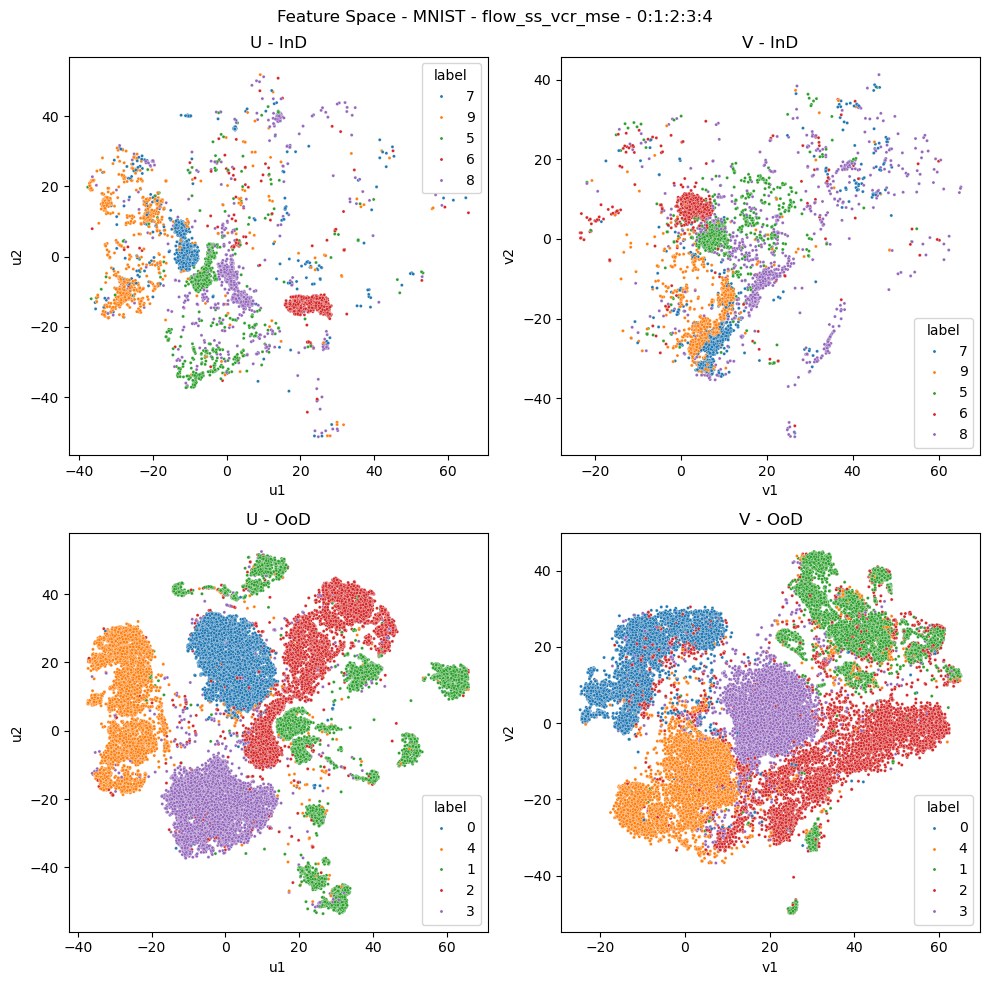

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.23s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.16s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.18s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:07,  2.51s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:05<00:05,  2.53s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.59s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.68s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]

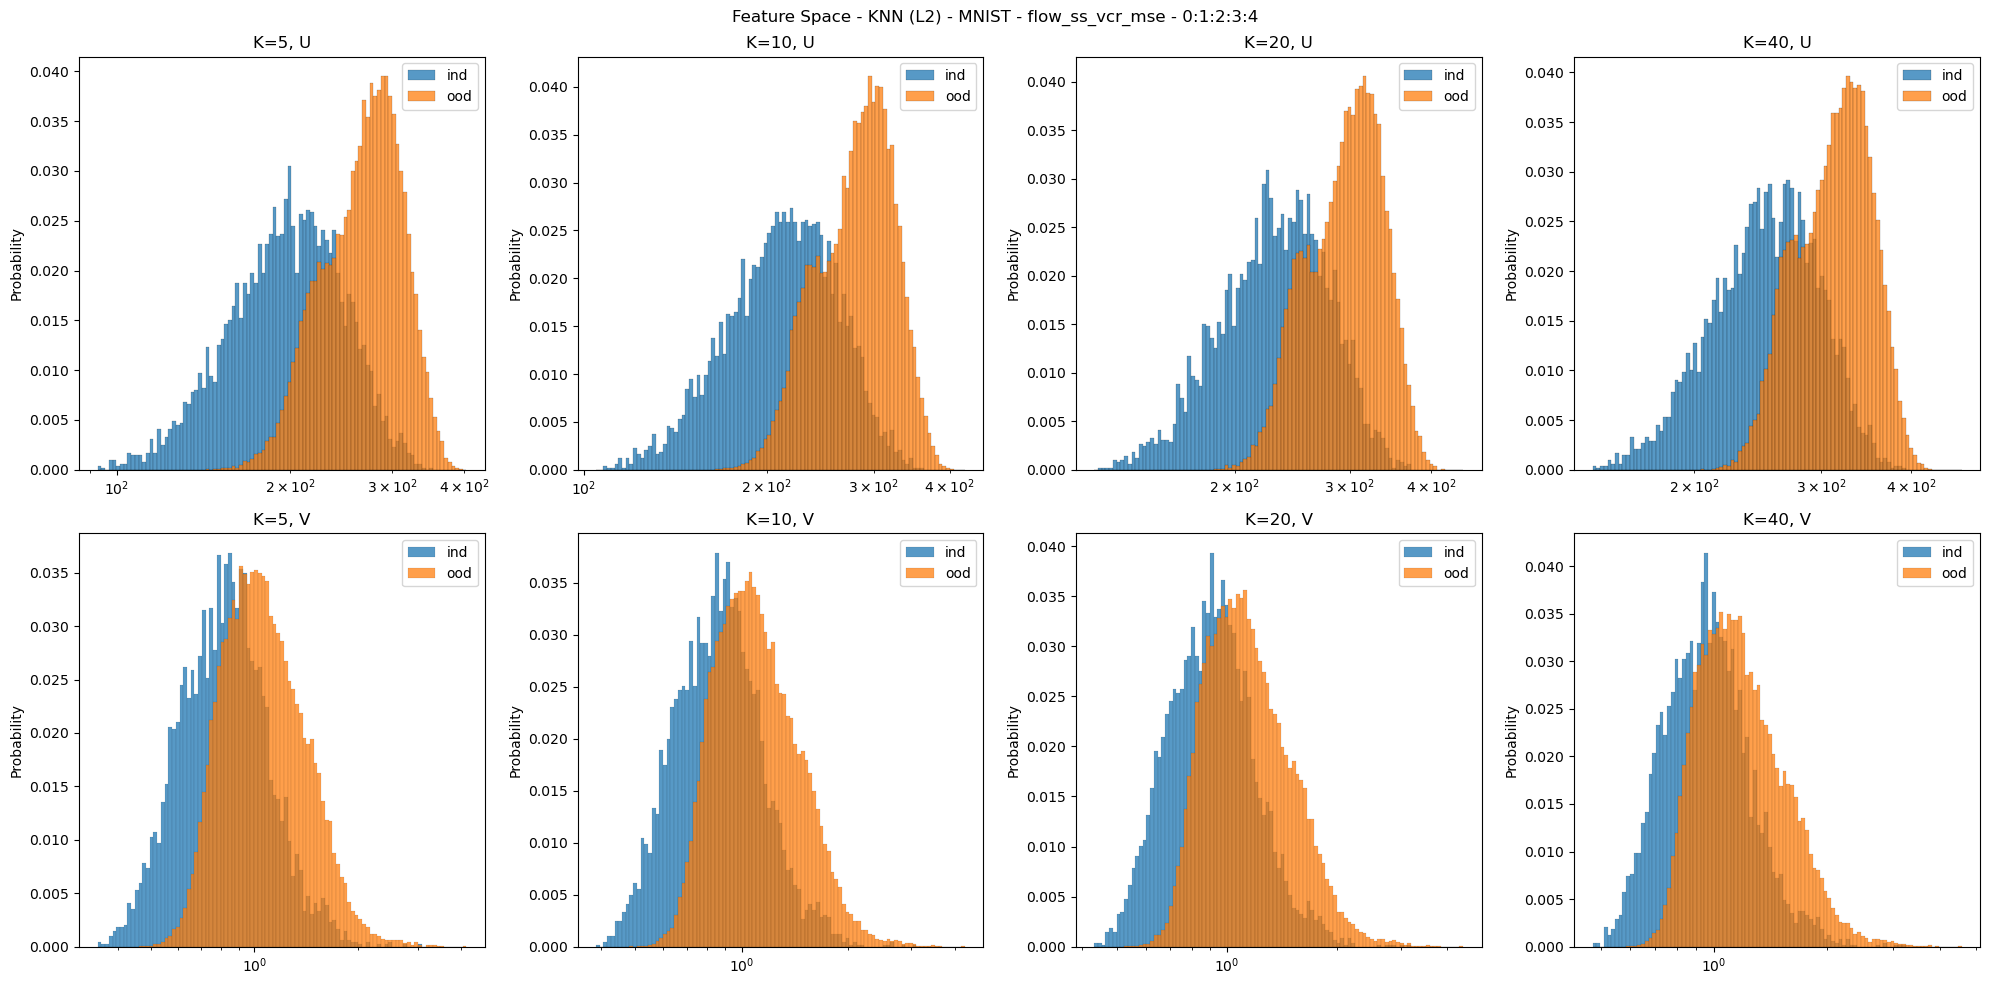

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.03s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.05s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:07,  2.46s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.49s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.54s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.59s/it]

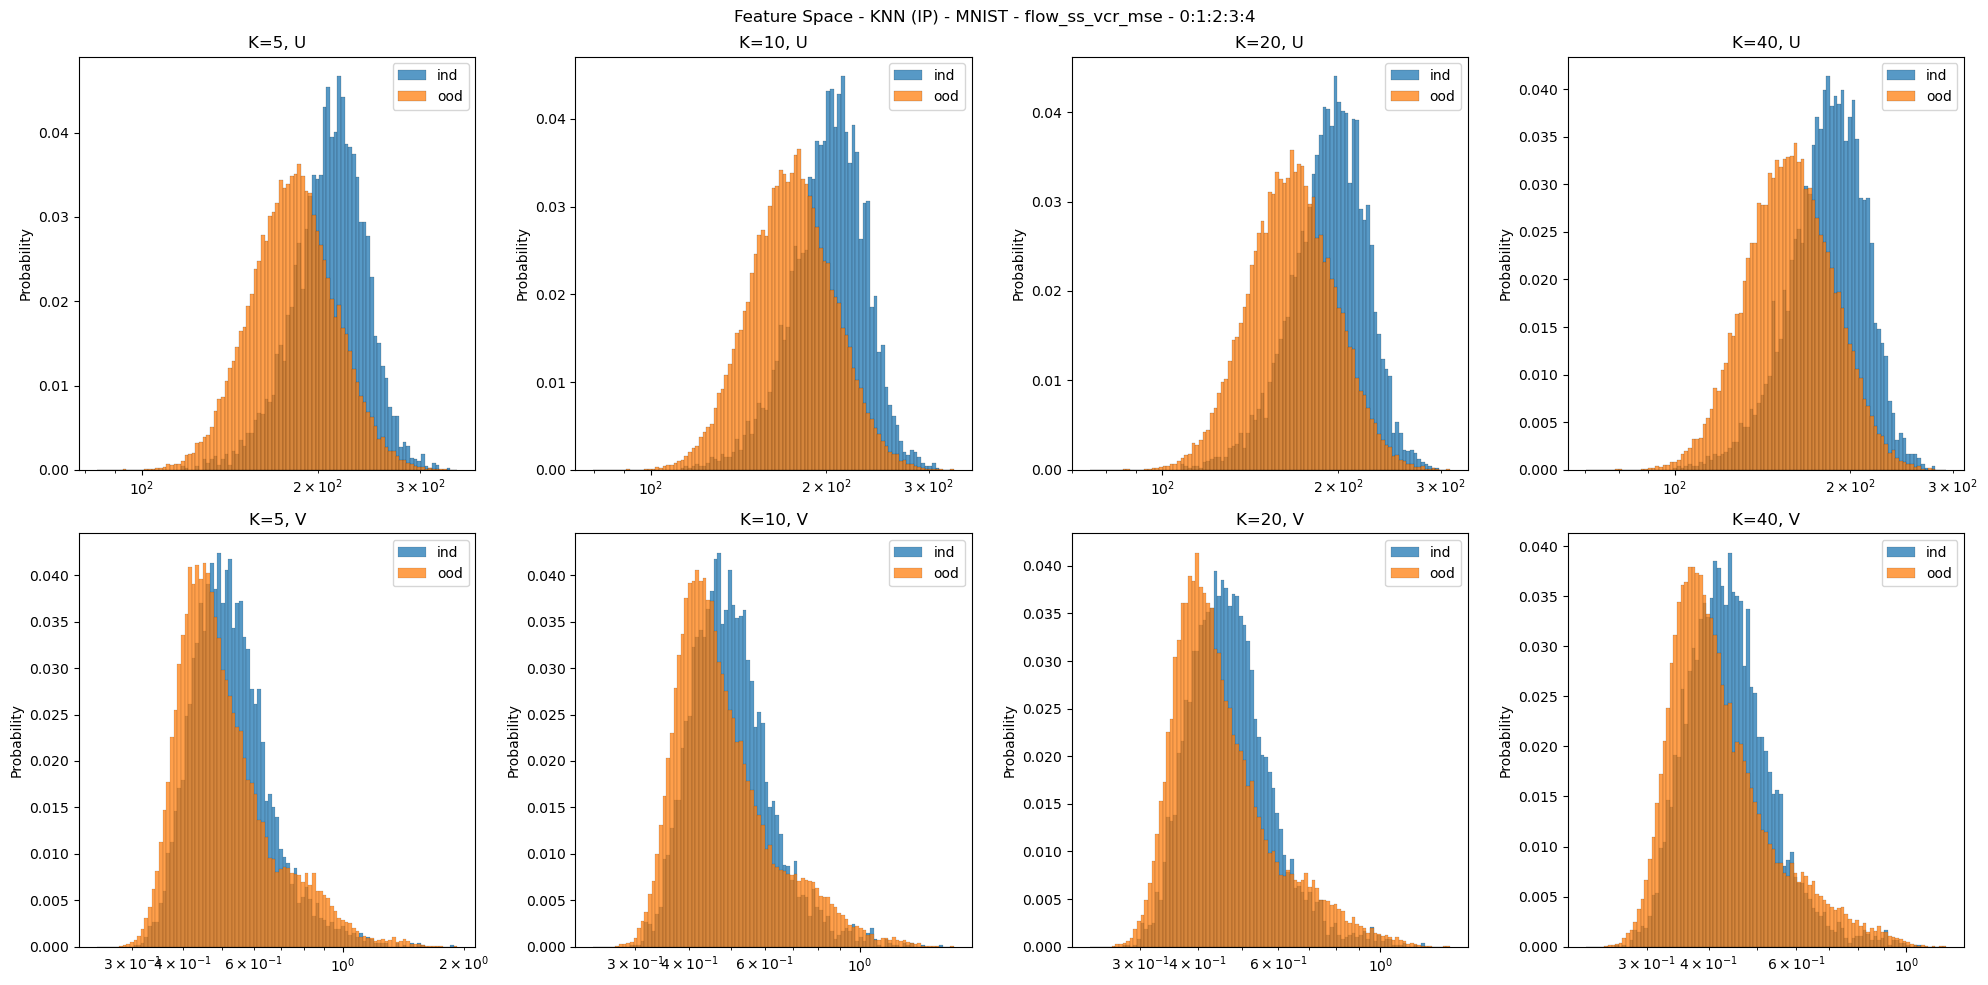

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

17.517273 0.80908865 0.9817235 0.13824129
17.476284 0.80070513 0.9829232 0.13787477
17.561852 0.8162635 0.97827744 0.13066523
17.734798 1.0313215 1.0529757 0.16761456
25.842558 1.2499185 24.836859 0.74484134


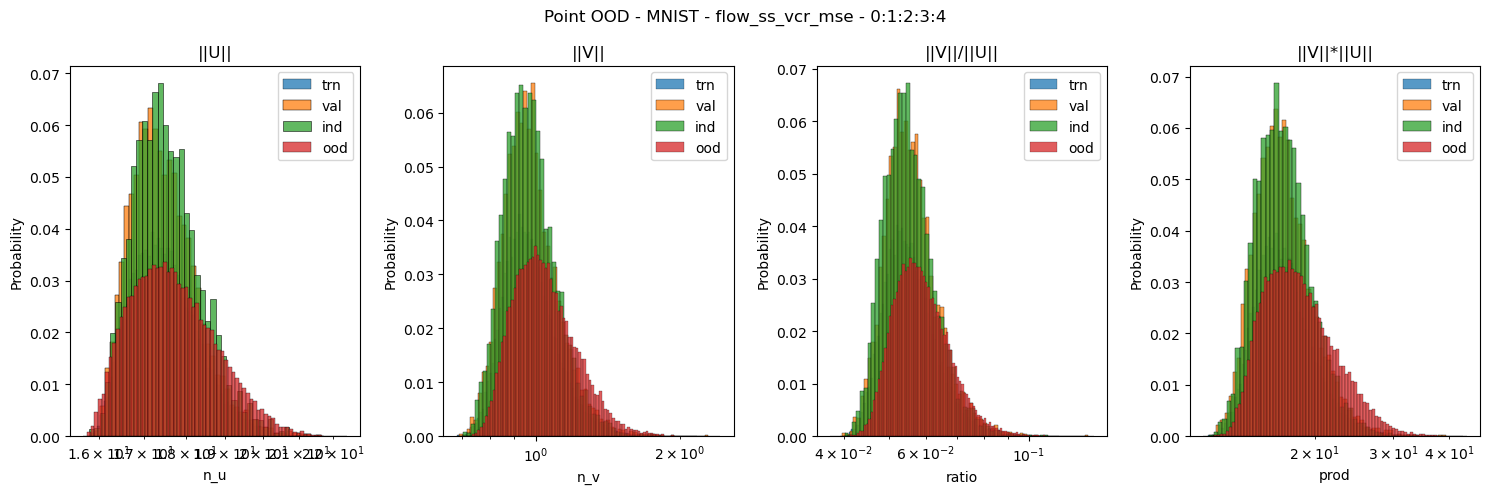

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


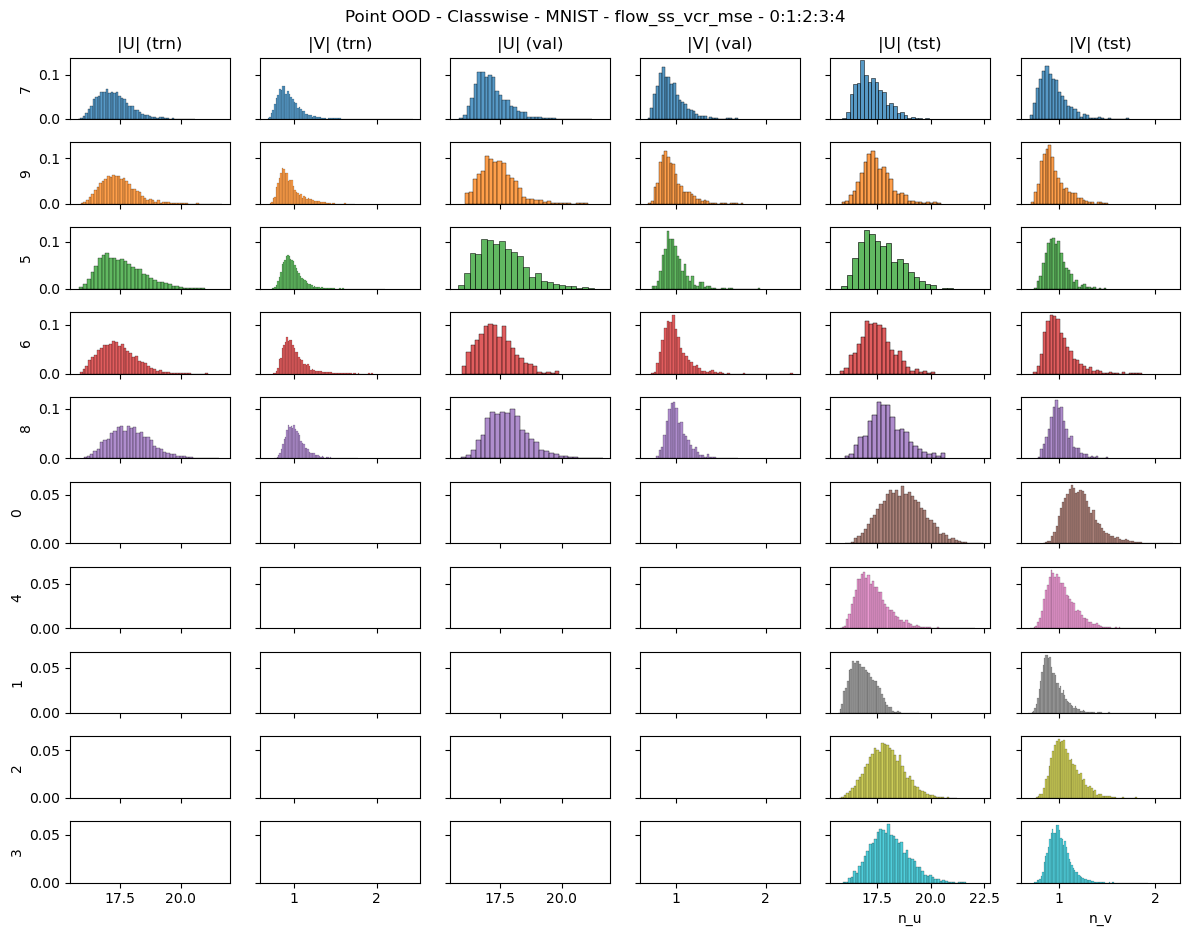

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

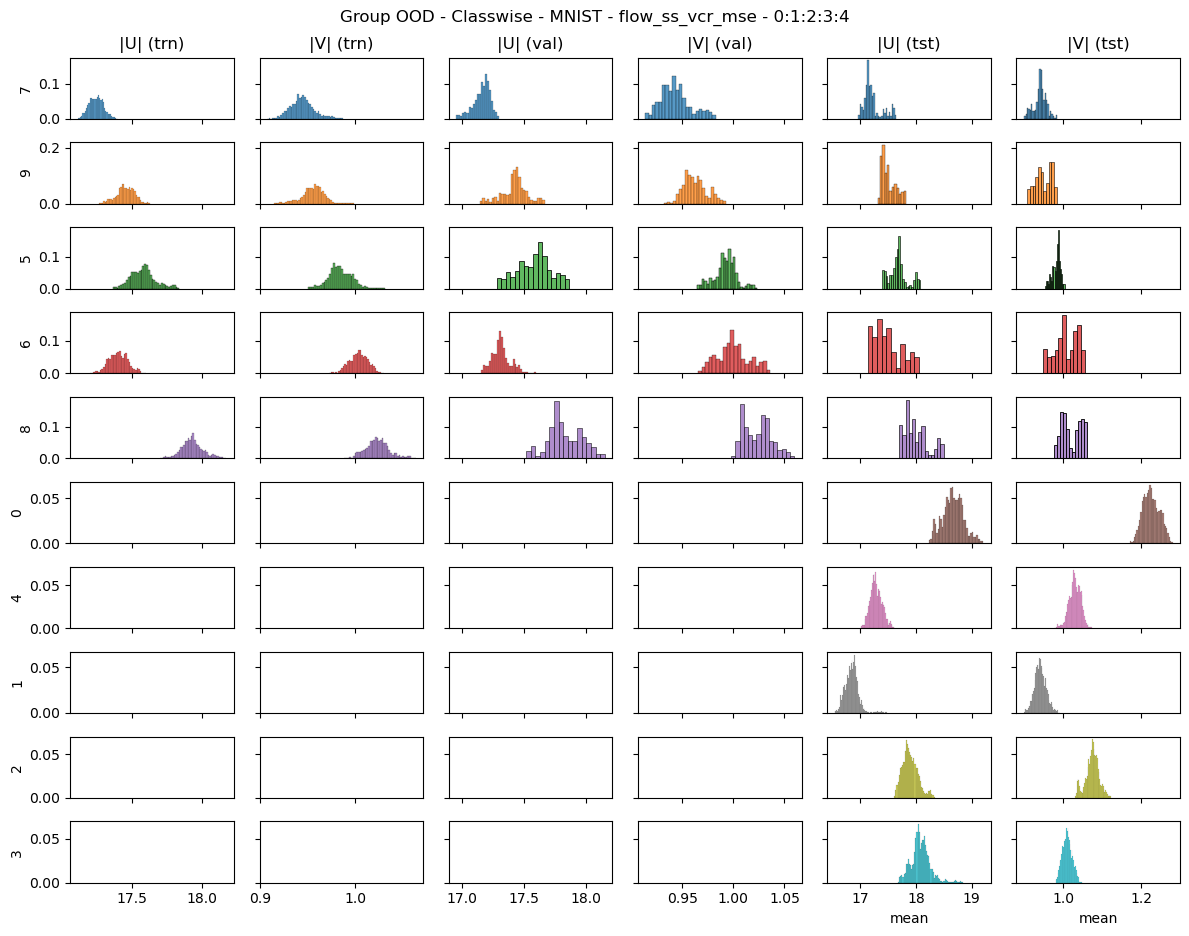

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

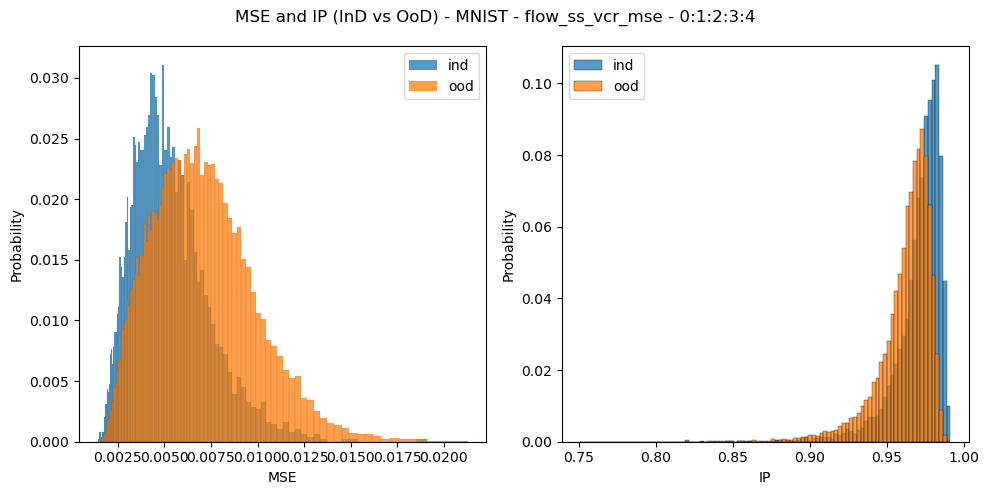

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()